### Objectif du notebook
* Evaluer les nouvelles réponses apportées aux questions de la fiche de tests, en utilisant comme référence notebooklm ou la réponse humaine si dispo 
* Méthode; 
    * positionner la réponse de référence face à pathrag (gpt5 mini), puis hypergraph rag (gpt5 mini + openai embed large), en 2 passes distinctes
    * évaluer avec un prompt structuré avec gemini 2.5 pro, avec comme consigne de choisir la réponse la + adaptée à un AAP pour convainvre un bailleur 

In [4]:
from openai import OpenAI, AsyncOpenAI
import time
import nest_asyncio
import os

nest_asyncio.apply()

from dotenv import load_dotenv

load_dotenv("/home/chougar/Documents/GitHub/.env")

openrouter_key = os.getenv("openrouter")
os.environ["openrouter"] = openrouter_key

In [5]:
reponses_list=[
    {
        "id": 26, 
        "question": "Résumé du projet en 250 caractères max", 
        "version": "base",
        "critique": "manque de chiffres et de détails", 
        "taille": 250,
        "notebooklm": """
            Le projet GAPADOU (« Forêt sacrée » en Anii) œuvre pour la gestion durable de 6 forêts sacrées au Bénin, dans le département de la Donga. Il vise à renforcer les capacités des communautés locales et des instances de gestion pour un modèle fonctionnel et pérenne de préservation face aux menaces de déforestation, pauvreté et érosion des croyances. Le projet s'étend sur 3 ans.""", 
        "pathrag_gpt_4o_mini": "The GAPADOU project aims to sustainably manage and conserve sacred forests in Benin's Donga department, enhancing community participation and governance while addressing environmental challenges and promoting local economic development.",
        "pathrag_gpt_5_mini": "GAPADOU: a 3‑year Planète Urgence project in Benin to protect, restore and sustainably manage six sacred forests via community governance (CLFS/CCSI), restoration, livelihoods (apiculture, agroforestry), education, research and a replicable guide.", 
        "hypergraph":"""
            GAPADOU protège et restaure six forêts sacrées au Bénin (578 ha), renforce gouvernance
            communautaire, développe AGR (apiculture, pépinières, écotourisme), plante 223 200 arbres sur 3 ans,
            et vise un modèle pérenne et réplicable (budget 1 095 255 €)."""
    },
    {
        "id": 27, 
        "question": "Description du projet (3000 caractères max)", 
        "version": "base",
        "critique": "manque de détails factuels et données chiffrées", 
        "taille": 3000,
        "notebooklm": """
            Le projet GAPADOU, dont le nom signifie "Forêt sacrée" en langue Anii, a pour objectif la préservation et la gestion durable des forêts sacrées au Bénin. Il est déployé dans six forêts sacrées (Sérou, Kilir, Adjandjan à Djougou et Igbo-Dogni, Igbo-Lakoun, Kikélé à Bassila), couvrant un total de 578 hectares dans le département de la Donga. Ce projet, d'une durée de 3 ans (juin 2026 - mai 2029), est la phase 2 et s'inscrit dans la continuité d'une phase pilote (2023) et d'une première phase (2024-2026).
            Les forêts sacrées du Bénin sont des sanctuaires boisés, essentiels pour la biodiversité et les pratiques spirituelles, mais elles sont menacées par la pression démographique, l'expansion agricole, le déclin des croyances traditionnelles et le manque de moyens des structures de gestion locale. L'objectif spécifique de GAPADOU est de renforcer les capacités des communautés locales et des instances de gestion de ces forêts pour créer un modèle fonctionnel, pérenne et réplicable. Il s'appuie sur un arrêté interministériel de 2012 qui a légalisé ces forêts et institué des Comités locaux de gestion des forêts sacrées (CLFS) et des Comités communaux de coordination et de suivi de l'intégration des forêts sacrées (CCSI), souvent inactifs faute de ressources.
            Le projet s'articule autour de trois composantes stratégiques, complétées par une composante transversale de gestion:
            1. Renforcement de la gouvernance des instances de gestion des forêts sacrées : Il accompagnera les six CLFS, déjà réactivés ou créés lors de la phase 1, pour renforcer leurs compétences organisationnelles et techniques en matière de protection et de restauration. Il soutiendra également la création de deux CCSI dans les communes de Bassila et Djougou. Une attention particulière est portée à l'intégration des femmes dans ces instances de gouvernance, à travers des formations en leadership. Les Plans d'Aménagement et de Gestion Simplifiés (PAGS) seront mis à jour ou élaborés de manière participative. Des actions de protection physique (plantations de ceintures épineuses, pare-feux, signalisation) et de restauration écologique (plantation d'espèces autochtones adaptées, régénération naturelle assistée, notamment pour des espèces menacées comme le Colobe magistrat) seront mises en œuvre.
            2. Renforcement de la pérennité économique des communautés et des instances de gestion : Cette composante vise à réduire la pression sur les forêts en développant des activités génératrices de revenus (AGR) durables pour les communautés locales. Cela inclut l'accompagnement des pépiniéristes, des agriculteurs en agroforesterie (avec des sites agroforestiers écoles) et des apiculteurs. Les femmes seront spécifiquement formées à la valorisation des produits forestiers non ligneux (karité, néré) et des produits agricoles. Le projet explorera également la création d'une caisse communautaire et une étude sur les opportunités économiques de l'écotourisme pour financer les instances de gestion.
            3. Mobilisation des acteurs par la sensibilisation, la communication et le plaidoyer : Des programmes d'éducation à l'environnement seront déployés dans les écoles primaires, avec la formation d'enseignants et la création de clubs environnementaux. Un travail de recherche, en partenariat avec l'Université de Parakou, documentera et valorisera l'histoire et les pratiques de conservation des forêts sacrées, dont la mémoire collective est menacée. Des campagnes de sensibilisation grand public (spots radio, tables rondes, jeux) seront également menées. Enfin, le projet fédérera les acteurs des forêts sacrées à l'échelle nationale pour le partage d'expériences et la co-construction d'un guide opérationnel réplicable.
            Le projet est piloté par Planète Urgence en collaboration avec ses partenaires locaux BEV ONG, YIMMA Bénin et l'Université de Parakou. Son coût global est de 1 095 255 EUR, co-financé à 50% par le FFEM et 50% par les fonds propres de Planète Urgence. L'ambition est de diffuser ce modèle exemplaire et innovant, contribuant ainsi à la gestion durable des près de 2900 forêts sacrées du Bénin et au-delà.        
        """
        , 
        "pathrag_gpt_4o_mini":"""
            The GAPADOU project is a comprehensive initiative focused on the sustainable management and conservation of sacred forests located in the Donga department of Benin. This project was launched in January 2024 and spans a three-year timeline, during which it aims to address various environmental and socio-economic challenges related to these crucial ecosystems.

            Sacred forests, referred to as "Forêt sacrée" in the local Anii language, hold significant cultural and spiritual importance to the surrounding communities. They have resisted deforestation thanks to local cultural beliefs, making them vital for biodiversity conservation and local livelihoods. The GAPADOU project seeks to foster community engagement and enhance governance structures surrounding these forests, promoting effective community management and environmental restoration.

            Key objectives of GAPADOU include:

            Sustainable Management Practices: The project is designed to implement strategies for managing six specific sacred forests. It will focus on creating favorable conditions for local communities while mitigating land use conflicts that can arise between farmers and beekeepers. As part of this, eco-friendly income-generating activities such as agroforestry and beekeeping will be promoted.

            Partnership Building: GAPADOU emphasizes the need to build partnerships at various levels—local, national, and international—to promote accountability and environmental governance. Collaboration with organizations like Planète Urgence and BEV ONG is critical to ensuring effective project execution and financial oversight.

            Community Engagement: Local communities play a crucial role in the success of the project. The initiative seeks to enhance community participation in resource management and to empower residents through training and educational workshops. This empowerment particularly focuses on improving women's participation in sustainable practices.

            Research and Capacity Building: In addition to project implementation, GAPADOU will conduct socio-economic studies and environmental research aimed at understanding agricultural practices and enhancing local livelihoods. Continuous monitoring and capacity-building initiatives will further promote resilience within the community.

            Biodiversity and Conservation Focus: The project targets the conservation of sacred forests while enhancing socio-economic conditions for local populations, thus appealing to both environmental preservation and community development.

            By integrating conservation efforts with community involvement, GAPADOU hopes to develop viable economic models while addressing critical issues such as poverty, hunger, climate change, and overall terrestrial life. The successful implementation of this initiative can serve as a blueprint for similar projects in other contexts, aligning with sustainable development goals.

            Overall, GAPADOU represents a significant step forward in bridging environmental conservation with social responsibility, targeting both biodiversity preservation and local community enhancement.

        """,
        "pathrag_gpt_5_mini": """
            GAPADOU est un projet pilote de conservation et de développement au Bénin visant à protéger, restaurer et garantir une gestion communautaire durable des forêts sacrées. Mis en œuvre depuis 2023 par un partenariat dirigé par Planète Urgence (bénéficiaire et principal implementateur) avec des opérateurs locaux tels que BEV ONG et YIMMA, ainsi que l'Université de Parakou et les autorités municipales, le projet concentre ses actions sur six forêts sacrées pilotes (~578 ha dans les communes de Bassila et Djougou) tout en concevant un dispositif reproductible pour une adoption plus large à travers le pays (potentiellement des milliers de forêts sacrées).
            Objectifs et portée

            Protéger et restaurer les forêts sacrées par la délimitation, la signalisation, l'établissement de pare-feux, la plantation/enrichissement et la régénération naturelle.
            Renforcer la gouvernance communautaire et les cadres juridiques-institutionnels en formant et en capacitant des comités de gestion des forêts sacrées locales (CLFS), en créant/opérationnalisant deux comités de suivi et d’intégration communaux (CCSI), et en mettant à jour ou en élaborant des plans de gestion et d'utilisation des terres simplifiés (PAGS).
            Réduire les pressions sur les forêts en soutenant des moyens de subsistance diversifiés et durables (apiculture, agroforesterie, plantes médicinales, petits animaux, production de champignons, transformation/ajout de valeur, mécanismes d'épargne communautaire) et en explorant des opportunités d'écotourisme.
            Documenter et valoriser les connaissances culturelles par la recherche participative avec les aînés, l'éducation à l'environnement dans les écoles, les campagnes de sensibilisation publique et des productions audiovisuelles.
            Produire des orientations opérationnelles, des outils de suivi et un modèle économique/financier reproductible pour assurer la viabilité et l'évolutivité à long terme.
            Activités clés et approches

            Élaboration participative des PAGS (inventaires, consultations publiques, ateliers de validation, validation administrative jusqu'aux arrêtés préfectoraux). BEV assure la facilitation technique des PAGS.
            Mesures de restauration et de protection : plantation, établissement de ceintures protectrices épineuses, signalisation et mesures de prévention des incendies.
            Moyens de subsistance : formation et soutien matériel pour les apiculteurs, pépiniéristes, producteurs agroforestiers ; création de fonds communautaires (caisses communautaires) ; études de faisabilité et modélisation commerciale pour un financement durable.
            Éducation & sensibilisation : YIMMA dirige l'éducation environnementale dans les écoles et la sensibilisation communautaire ; production de matériaux documentaires et de communication ; campagnes radio en langues locales.
            Recherche & suivi : inventaires de biodiversité, suivis avec des outils (e.g., IMET), recherche appliquée par l'Université de Parakou sur la régénération et la base de données sur les espèces.
            Gouvernance & renforcement des capacités : formation au leadership féminin (objectif : 40 femmes dans 8 villages), renforcement organisationnel pour BEV, formation/activation des CCSI et coordination multi-niveau via des comités directeurs opérationnels et stratégiques.
            Organisation, calendrier et finances

            Principal implementateur : Planète Urgence assure la supervision stratégique, la coordination technique, administrative et financière et un cofinancement de 50 % de ses fonds FORET. Mise en œuvre locale par BEV ONG et YIMMA, avec un soutien de recherche de l'Université de Parakou.
            Durée : une phase de trois ans (juin 2026–mai 2029) est détaillée dans les documents de planification (s'appuyant sur les actions pilotes commencées en 2024).
            Budget : total 1 095 255 € ; contribution proposée du FFEM 547 628 € (50 %), Planète Urgence cofinançant le reste.
            Résultats attendus

            Amélioration de la protection et de l'état des forêts sacrées pilotes ; gouvernance communautaire renforcée, inclusive et juridiquement ancrée ; mémoire culturelle documentée et sensibilisation environnementale accrue ; moyens de subsistance diversifiés et viables réduisant la pression forestière ; un guide opérationnel validé et un modèle économique permettant la réplication et l'évolutivité. Des évaluations externes de suivi, de mi-parcours et finales sont prévues pour capturer les leçons et assurer la responsabilité.        
        """, 
        "hypergraph":"""
            Le projet GAPADOU vise la protection, la restauration et la gestion durable de forêts sacrées au Bénin, en articulant conservation de la biodiversité, renforcement des gouvernances locales et développement d’alternatives économiques durables. Identifié en juin 2025, il couvre six forêts sacrées situées dans les communes de Bassila et Djougou (Kikélé, Igbo Lakoun, Igbo‑Dogni, Sérou, Kilir, Adjandjan) et s’appuie sur l’ancrage local d’organisations partenaires (Planète Urgence, BEV ONG, YIMMA‑Bénin, Université de Parakou) et sur les instances locales (CLFS, CCSI, mairies, services Eaux‑Forêts). Le projet démarre le 01/06/2026 pour une durée de 3 ans (juin 2026–mai 2029).

            Structure et axes d’intervention
            - Composante 1 — Renforcement de la gouvernance : réactivation et consolidation de six Comités Locaux de Forêts Sacrées (CLFS) et création de deux CCSI, renforcement des capacités organisationnelles et techniques, intégration des femmes dans les instances décisionnelles, sécurisation foncière et formalisation des conventions locales.
            - Composante 2 — Pérennité économique : promotion d’activités génératrices de revenus (apiculture, agroforesterie, transformation de produits non ligneux, pisciculture légère, etc.), exploration de mécanismes d’épargne communautaire et d’un potentiel d’écotourisme durable afin d’assurer des ressources de financement locales pour les instances de gestion.
            - Composante 3 — Mobilisation, sensibilisation et capitalisation : éducation à l’environnement dans les écoles (EEDD), communication grand public, recherche sociologique pour documenter et préserver la mémoire collective orale liée aux forêts sacrées, mise en réseau des acteurs et production d’un guide pratique.
            - Composante transversale — Gestion de projet : coordination transparente et locale pilotée par Planète Urgence (délégation Bénin), suivi‑évaluation et redevabilité (SERA), audits, évaluations externes, renforcement des partenaires locaux et capitalisation des enseignements.

            Objectifs opérationnels et cibles
            - Restaurer et restaurer la couverture forestière : 223 200 arbres plantés sur 3 ans et restauration estimée de 828 hectares par régénération et plantations adaptées.
            - Améliorer la gouvernance locale et la capacité opérationnelle des CLFS/CCSI pour garantir gestion durable et autonomie.
            - Réduire la pression anthropique via alternatives économiques et sensibilisation, en visant la durabilité financière des instances locales.
            - Documenter et valoriser les valeurs culturelles et savoirs traditionnels pour renforcer l’acceptabilité sociale des mesures de conservation.

            Modalités et garanties
            Le budget global est de 1 095 255 €, financé à 50 % par le FFEM (547 628 €) et à 50 % par les fonds propres de Planète Urgence. Le montage institutionnel repose sur des conventions de partenariat et avenants annuels avec BEV, YIMMA, collectivités et services techniques; le projet affirme une neutralité politique, le respect des usages coutumiers et l’obtention de consentements libres et éclairés des parties prenantes. Des outils logistiques (GPS, drone, 4 motos), missions du siège et une évaluation externe intermédiaire sont prévus pour garantir suivi technique et transparence.

            Caractère exemplaire
            GAPADOU agit sur des zones de biodiversité peu documentées (forêts sacrées), combine restauration écologique, sauvegarde culturelle et modèles économiques locaux réplicables. Il a pour ambition de produire un modèle fonctionnel, pérenne et reproductible pour la gestion durable des forêts sacrées au Bénin et au‑delà.         
        """
    },
    {
        "id": 27, 
        "question": "Description du projet en repartant de l'historique, des éléments déclencheurs et incluant des faits, chiffres et détails techniques (3000 caractères max)", 
        "version": "question reformulée",
        "critique": "manque de détails factuels et données chiffrées", 
        "taille": 3000,
        "notebooklm": """
            Le projet GAPADOU, dont le nom signifie "Forêt sacrée" en langue Anii, a pour objectif la préservation et la gestion durable des forêts sacrées au Bénin. Il est déployé dans six forêts sacrées (Sérou, Kilir, Adjandjan à Djougou et Igbo-Dogni, Igbo-Lakoun, Kikélé à Bassila), couvrant un total de 578 hectares dans le département de la Donga. Ce projet, d'une durée de 3 ans (juin 2026 - mai 2029), est la phase 2 et s'inscrit dans la continuité d'une phase pilote (2023) et d'une première phase (2024-2026).
            Les forêts sacrées du Bénin sont des sanctuaires boisés, essentiels pour la biodiversité et les pratiques spirituelles, mais elles sont menacées par la pression démographique, l'expansion agricole, le déclin des croyances traditionnelles et le manque de moyens des structures de gestion locale. L'objectif spécifique de GAPADOU est de renforcer les capacités des communautés locales et des instances de gestion de ces forêts pour créer un modèle fonctionnel, pérenne et réplicable. Il s'appuie sur un arrêté interministériel de 2012 qui a légalisé ces forêts et institué des Comités locaux de gestion des forêts sacrées (CLFS) et des Comités communaux de coordination et de suivi de l'intégration des forêts sacrées (CCSI), souvent inactifs faute de ressources.
            Le projet s'articule autour de trois composantes stratégiques, complétées par une composante transversale de gestion:
            1. Renforcement de la gouvernance des instances de gestion des forêts sacrées : Il accompagnera les six CLFS, déjà réactivés ou créés lors de la phase 1, pour renforcer leurs compétences organisationnelles et techniques en matière de protection et de restauration. Il soutiendra également la création de deux CCSI dans les communes de Bassila et Djougou. Une attention particulière est portée à l'intégration des femmes dans ces instances de gouvernance, à travers des formations en leadership. Les Plans d'Aménagement et de Gestion Simplifiés (PAGS) seront mis à jour ou élaborés de manière participative. Des actions de protection physique (plantations de ceintures épineuses, pare-feux, signalisation) et de restauration écologique (plantation d'espèces autochtones adaptées, régénération naturelle assistée, notamment pour des espèces menacées comme le Colobe magistrat) seront mises en œuvre.
            2. Renforcement de la pérennité économique des communautés et des instances de gestion : Cette composante vise à réduire la pression sur les forêts en développant des activités génératrices de revenus (AGR) durables pour les communautés locales. Cela inclut l'accompagnement des pépiniéristes, des agriculteurs en agroforesterie (avec des sites agroforestiers écoles) et des apiculteurs. Les femmes seront spécifiquement formées à la valorisation des produits forestiers non ligneux (karité, néré) et des produits agricoles. Le projet explorera également la création d'une caisse communautaire et une étude sur les opportunités économiques de l'écotourisme pour financer les instances de gestion.
            3. Mobilisation des acteurs par la sensibilisation, la communication et le plaidoyer : Des programmes d'éducation à l'environnement seront déployés dans les écoles primaires, avec la formation d'enseignants et la création de clubs environnementaux. Un travail de recherche, en partenariat avec l'Université de Parakou, documentera et valorisera l'histoire et les pratiques de conservation des forêts sacrées, dont la mémoire collective est menacée. Des campagnes de sensibilisation grand public (spots radio, tables rondes, jeux) seront également menées. Enfin, le projet fédérera les acteurs des forêts sacrées à l'échelle nationale pour le partage d'expériences et la co-construction d'un guide opérationnel réplicable.
            Le projet est piloté par Planète Urgence en collaboration avec ses partenaires locaux BEV ONG, YIMMA Bénin et l'Université de Parakou. Son coût global est de 1 095 255 EUR, co-financé à 50% par le FFEM et 50% par les fonds propres de Planète Urgence. L'ambition est de diffuser ce modèle exemplaire et innovant, contribuant ainsi à la gestion durable des près de 2900 forêts sacrées du Bénin et au-delà.                
        """, 
        "pathrag_gpt_4o_mini": """
            Description et Mission

            GAPADOU est une initiative complète dédiée à la gestion durable et à la conservation des forêts sacrées au Bénin. Lancé en janvier 2024, il s'étend sur une période de trois ans visant à répondre à divers Objectifs de Développement Durable (ODD), notamment la réduction de la pauvreté, la sécurité alimentaire et la préservation de la vie terrestre. Plus particulièrement, le projet se concentre sur les forêts sacrées situées dans les communes locales de Djougou et Bassila, où il engage les parties prenantes locales pour améliorer la gouvernance, la sécurité foncière et l'implication des communautés dans les pratiques de gestion forestière.

            Contexte Historique et Déclencheurs

            Le projet s'appuie sur des initiatives antérieures, notamment le PIFSAP (Projet d'Intégration des Forêts Sacrées dans le système des Aires Protégées), qui a posé les bases pour reconnaître et améliorer la gestion des forêts sacrées. Les réalisations du PIFSAP incluent l'adoption d'un cadre réglementaire pour la gestion forestière, mettant l'accent sur l'engagement des communautés locales. Cependant, des défis tels que l'extrême pauvreté parmi les communautés rurales, une gouvernance ineffective et la pression croissante de l'expansion agricole ont rendu nécessaire la création de GAPADOU pour garantir la durabilité à long terme et la préservation culturelle de ces écosystèmes vitaux.

            Activités Clés et Objectifs

            GAPADOU comprend diverses activités visant à favoriser des pratiques durables, notamment :

            Établissement de Centres Communautaires pour les Forêts Sacrées (CCSF) : L'une des initiatives principales consiste en la création de comités dédiés à la gestion des forêts sacrées, intégrant les intérêts communautaires et soutenant les familles agricoles à travers des activités génératrices de revenus durables.

            Lutte contre la Déforestation : Le projet s'attaque aux causes de la déforestation en promouvant un modèle économique durable axé sur l'écotourisme et l'agriculture durable.

            Amélioration de la Gouvernance Locale : Il utilise des approches participatives pour améliorer la prise de décision et la gouvernance concernant la gestion forestière, intégrant des outils numériques pour une plus grande efficacité.

            Éducation et Renforcement des Capacités : GAPADOU intègre des programmes éducatifs sur la conservation des forêts et la biodiversité, visant à renforcer les capacités locales en matière de pratiques durables.

            Impact et Bénéficiaires

            Environ 6 000 personnes, dont environ 900 femmes, sont directement impactées par GAPADOU, car le projet améliore à la fois leurs moyens de subsistance et leur implication dans la gestion forestière. L'initiative cible également l'amélioration des services communautaires essentiels, contribuant à améliorer les conditions de vie des personnes entourant les forêts sacrées.

            Détails Techniques et Opérationnels

            Le budget total du projet GAPADOU est estimé à 1 095 255 €, avec un financement provenant de diverses entités publiques et privées.

            La mise en œuvre repose sur la collaboration entre des ONG malaisiennes telles que Planète Urgence et BEV ONG, qui fournissent un soutien technique et opérationnel vital.

            Le projet établit des mécanismes de suivi et d'évaluation continus pour apprécier ses progrès et garantir l'efficacité des pratiques de gestion, contribuant à la viabilité à long terme des forêts sacrées.

            À travers son approche multifacette, GAPADOU vise à créer un cadre durable qui non seulement protège le patrimoine environnemental des forêts sacrées au Bénin, mais renforce également la résilience socio-économique des populations locales. Ce faisant, il aborde les défis entrelacés de la pauvreté, de l'éducation et du changement climatique.
        """,
        
        "pathrag_gpt_5_mini": """ 
            Présentation

            GAPADOU est un projet pilote de conservation et de développement au Bénin axé sur la protection, la restauration et la gestion durable des forêts sacrées. Il cible six forêts sacrées pilotes (≈578 ha) dans les communes de Djougou et Bassila tout en visant à générer un modèle opérationnel et reproductible pour la gestion de nombreux autres sites (le pays compte environ 2 900 forêts sacrées).
            Historique et facteurs déclencheurs

            S'appuie sur des initiatives antérieures, notamment le PIFSAP (c.2011–2014) qui a reconnu légalement environ 90 forêts sacrées, produit des plans de gestion simplifiés (PAGS) et mené de grandes campagnes de plantation et d'inventaires. Le suivi limité à long terme du PIFSAP, un faible engagement communautaire sur certains sites et une durabilité financière fragile ont motivé une approche révisée centrée sur la communauté.
            Des évaluations et des diagnostics (BIOPAMA, évaluation PIFSAP, pilotes locaux) et une évaluation IMET de 2021 ont informé la conception de GAPADOU. Une phase pilote de 2024 (Phase 1) a permis la création de pépinières, des plantations et la formation de comités, et a intégré les enseignements dans la phase formelle de GAPADOU de trois ans (juin 2026–mai 2029) prévue pour la mise en œuvre complète.
            Planète Urgence est l'implementateur principal et co-financier ; BEV ONG et YIMMA Bénin sont les principaux partenaires locaux de mise en œuvre ; l'Université de Parakou fournit un soutien à la recherche.
            Objectifs et piliers

            Restaurer et protéger les forêts sacrées (démarcation, signalisation, pare-feux, plantations d'enrichissement, ceintures de ronces).
            Renforcer la gouvernance participative (formation/renforcement des CLFS, création de deux CCSI, mise à jour/production de PAGS, validation légale par des arrêtés préfectoraux).
            Réduire la pression via les moyens de subsistance (apiculture, agroforesterie, pépinières, petit bétail, valorisation, épargne communautaire) et explorer l'écotourisme.
            Documenter et valoriser la mémoire culturelle (recherche participative avec les aînés, productions audiovisuelles).
            Surveiller la biodiversité et produire des outils de capitalisation (guide opérationnel, modèle de reproduction).
            Faits, chiffres, détails techniques

            Budget total du projet : 1 095 255 € ; contribution FFEM demandée 547 628 € (50 %) ; Planète Urgence fournit environ 50 % de cofinancement à partir de ses fonds FORET et de ses partenaires.
            Durée du projet : 3 ans (01/06/2026–mai 2029) avec des pilotes antérieurs depuis 2023–2024.
            Couverture pilote : six forêts sacrées (~578 ha) ; réalisations de la phase 1 (pilote 2024–2026) : 6 pépinières créées, 12 pépiniéristes formés, réactivation de 6 CLFS, renforcement des capacités de 518 planteurs, éducation environnementale dans 5 écoles (≈1 520 élèves), plantation d'environ 73 000 arbres dans/aux alentours des forêts sacrées et ~337 000 sur des parcelles bénéficiaires.
            Principaux résultats : 6 PAGS mis à jour/créés, organes de gouvernance (CLFS, 2 CCSI), parcelles démonstratives d'agroforesterie (7 municipales), modèles économiques et études de faisabilité pour l'AGR et l'écotourisme, guide opérationnel pour la reproduction.
            Suivi et outils : indicateurs et tableaux de bord alignés sur le cadre logique (bénéficiaires répartis par genre/vulnérabilité, hectares protégés/restaurés, formations, GES évités), inventaires de biodiversité (s'appuyant sur les inventaires PIFSAP 2012), utilisation de l'IMET et recherche appliquée (Université de Parakou).
            Équipement de terrain : GPS, drone, 4 motos pour le suivi et les opérations.
            Gouvernance : Planète Urgence coordonne le CPO (opérationnel) et le CPS (stratégique), signe des conventions de partenariat avec les partenaires de mise en œuvre, et prévoit des évaluations externes à mi-parcours et finales ainsi que des audits.
            Risques et atténuation

            Principaux risques : changement climatique (sécheresse, incendies), conflits d’utilisation des terres, faible adhésion communautaire. Atténuation : mesures d'adaptation (prévention des incendies, plantations résistantes à la sécheresse), clarification des droits fonciers via les PAGS et validation administrative, processus participatifs solides, formation des femmes au leadership et options de subsistance diversifiées.
            Ce design vise à combiner la restauration écologique, la valorisation culturelle et les moyens de subsistance durables pour garantir la protection à long terme et la reproduction de la gestion des forêts sacrées au Bénin.
        """, 
        "hypergraph":"""
            Contexte et genèse
            Le projet GAPADOU prend appui sur une longue histoire de reconnaissance des forêts sacrées au Bénin (travaux scientifiques dès les années 1930, actions UNESCO depuis les années 1980–2000) et sur des initiatives nationales récentes (PIFSAP, arrêté interministériel et plans d’aménagement et de gestion simplifiés – PAGS). Entre 2021 et 2025, des actions pilotes menées par Planète Urgence, BEV ONG et YIMMA ont permis d’identifier six forêts sacrées (Sérou, Kilir, Adjandjan, Kikélé, Igbo Lakoun, Igbo‑Dogni) couvrant 578 ha et de tester des approches de restauration, gouvernance et économie locale. Ces expérimentations ont révélé que le statut sacré seul ne suffit plus à protéger ces sites face à la pression démographique, à la demande en terres agricoles et au bois de chauffe, et que la dégradation climatique (sécheresses, feux tardifs liés à la chasse) augmente les risques.

            Éléments déclencheurs et justification
            Les enseignements des phases pilotes (réactivation de 6 CLFS, premières pépinières, plus de 500 reboiseurs formés, lancement d’AGR comme apiculture et agroforesterie) et les diagnostics locaux (y compris une analyse de conflits sur la forêt de Sérou, avril 2025, conduite par BEV/GIZ‑ZFD) ont montré l’urgence d’un dispositif intégré et pérenne. La fragilité des droits fonciers (PAGS obsolètes, insécurité foncière des femmes), la faiblesse des moyens techniques des services forestiers et le risque climatique ont conduit à formuler une réponse structurée combinant gouvernance, restauration écologique et modèles économiques durables.

            Objectifs et cibles chiffrées
            GAPADOU vise à créer un modèle fonctionnel, pérenne et réplicable de gestion des forêts sacrées. Sur 3 ans (01/06/2026–mai 2029), le projet prévoit notamment la plantation de 223 200 arbres et la restauration par régénération de 828 hectares. Il s’appuie sur un budget global de 1 095 255 € (50 % FFEM : 547 628 €, 50 % fonds propres Planète Urgence).

            Approche technique et activités clés
            Le dispositif combine quatre volets : (1) renforcement de la gouvernance des instances locales (6 CLFS accompagnés, création de 2 CCSI, intégration des femmes), (2) renforcement de la pérennité économique (développement d’AGR : apiculture, plantes médicinales, petit élevage, champignons ; exploration de l’écotourisme ; mécanismes d’épargne communautaire), (3) mobilisation et sensibilisation (recherche sociologique, EEDD dans les écoles, communication, réseau de partage d’expériences et publication collective), (4) gestion de projet et capitalisation (transfert de compétences, suivi‑évaluation, audits). Le matériel prévu comprend un GPS pour le traçage des parcelles, un drone pour le suivi des plantations et 4 motos pour la logistique terrain. Les indicateurs et le cadre logique sont détaillés en Annexe 1.

            Gouvernance et partenariats
            Planète Urgence assure la maîtrise d’ouvrage et coordonne avec BEV ONG (mise en œuvre terrain), YIMMA (EEDD) et l’Université de Parakou (recherches sur régénération et perceptions). Le pilotage repose sur un Comité de Pilotage Opérationnel (réunions mensuelles), un Comité de Pilotage Stratégique (réunions semestrielles) et un Comité Finance (trimestriel). Des conventions et avenants annuels formalisent les partenariats.

            Risques et mesures d’adaptation
            Les principaux risques identifiés sont l’aggravation des changements climatiques (feux, sécheresses) et les conflits d’usage foncier. Le projet intègre des mesures d’adaptation (techniques d’irrigation/gestion de l’eau, plans de sécurité, mise à jour des PAGS, sensibilisation et médiation) et une démarche de co‑construction avec les communautés pour garantir l’adhésion et la pérennité.

            Impact attendu et reproductibilité
            Au‑delà de la restauration écologique locale, GAPADOU ambitionne d’offrir un modèle reproductible pour les ~2 900 forêts sacrées du Bénin, en produisant un guide opérationnel, en fédérant un réseau d’acteurs et en démontrant des modèles économiques locaux pour financer durablement les instances de gestion.
        """
    },
    {
        "id": 27, 
        "question": "Description du projet (4200 caractères max)", 
        "version": "taille réponse étendue",
        "critique": "manque de détails factuels et données chiffrées", 
        "taille": 4200,
        "notebooklm": """
            Le projet GAPADOU, dont le nom signifie "Forêt sacrée" en langue Anii, a pour objectif la préservation et la gestion durable des forêts sacrées au Bénin. Il est déployé dans six forêts sacrées (Sérou, Kilir, Adjandjan à Djougou et Igbo-Dogni, Igbo-Lakoun, Kikélé à Bassila), couvrant un total de 578 hectares dans le département de la Donga. Ce projet, d'une durée de 3 ans (juin 2026 - mai 2029), est la phase 2 et s'inscrit dans la continuité d'une phase pilote (2023) et d'une première phase (2024-2026).
            Les forêts sacrées du Bénin sont des sanctuaires boisés, essentiels pour la biodiversité et les pratiques spirituelles, mais elles sont menacées par la pression démographique, l'expansion agricole, le déclin des croyances traditionnelles et le manque de moyens des structures de gestion locale. L'objectif spécifique de GAPADOU est de renforcer les capacités des communautés locales et des instances de gestion de ces forêts pour créer un modèle fonctionnel, pérenne et réplicable. Il s'appuie sur un arrêté interministériel de 2012 qui a légalisé ces forêts et institué des Comités locaux de gestion des forêts sacrées (CLFS) et des Comités communaux de coordination et de suivi de l'intégration des forêts sacrées (CCSI), souvent inactifs faute de ressources.
            Le projet s'articule autour de trois composantes stratégiques, complétées par une composante transversale de gestion:
            1. Renforcement de la gouvernance des instances de gestion des forêts sacrées : Il accompagnera les six CLFS, déjà réactivés ou créés lors de la phase 1, pour renforcer leurs compétences organisationnelles et techniques en matière de protection et de restauration. Il soutiendra également la création de deux CCSI dans les communes de Bassila et Djougou. Une attention particulière est portée à l'intégration des femmes dans ces instances de gouvernance, à travers des formations en leadership. Les Plans d'Aménagement et de Gestion Simplifiés (PAGS) seront mis à jour ou élaborés de manière participative. Des actions de protection physique (plantations de ceintures épineuses, pare-feux, signalisation) et de restauration écologique (plantation d'espèces autochtones adaptées, régénération naturelle assistée, notamment pour des espèces menacées comme le Colobe magistrat) seront mises en œuvre.
            2. Renforcement de la pérennité économique des communautés et des instances de gestion : Cette composante vise à réduire la pression sur les forêts en développant des activités génératrices de revenus (AGR) durables pour les communautés locales. Cela inclut l'accompagnement des pépiniéristes, des agriculteurs en agroforesterie (avec des sites agroforestiers écoles) et des apiculteurs. Les femmes seront spécifiquement formées à la valorisation des produits forestiers non ligneux (karité, néré) et des produits agricoles. Le projet explorera également la création d'une caisse communautaire et une étude sur les opportunités économiques de l'écotourisme pour financer les instances de gestion.
            3. Mobilisation des acteurs par la sensibilisation, la communication et le plaidoyer : Des programmes d'éducation à l'environnement seront déployés dans les écoles primaires, avec la formation d'enseignants et la création de clubs environnementaux. Un travail de recherche, en partenariat avec l'Université de Parakou, documentera et valorisera l'histoire et les pratiques de conservation des forêts sacrées, dont la mémoire collective est menacée. Des campagnes de sensibilisation grand public (spots radio, tables rondes, jeux) seront également menées. Enfin, le projet fédérera les acteurs des forêts sacrées à l'échelle nationale pour le partage d'expériences et la co-construction d'un guide opérationnel réplicable.
            Le projet est piloté par Planète Urgence en collaboration avec ses partenaires locaux BEV ONG, YIMMA Bénin et l'Université de Parakou. Son coût global est de 1 095 255 EUR, co-financé à 50% par le FFEM et 50% par les fonds propres de Planète Urgence. L'ambition est de diffuser ce modèle exemplaire et innovant, contribuant ainsi à la gestion durable des près de 2900 forêts sacrées du Bénin et au-delà.                
        """, 
        "pathrag_gpt_4o_mini":"""
            Aperçu du projet GAPADOU
            Le projet GAPADOU est une initiative significative axée sur la promotion de la gestion durable et de la conservation des forêts sacrées au Bénin. Lancé en janvier 2024, le projet représente un engagement substantiel à aborder divers Objectifs de Développement Durable (ODD), en particulier en matière de réduction de la pauvreté, de sécurité alimentaire, de résilience face au changement climatique et de préservation des écosystèmes terrestres.

            Objectifs et buts
            GAPADOU vise à autonomiser les communautés rurales appauvries en favorisant des améliorations de la gouvernance, la sécurité des terres et l'implication des communautés dans les pratiques de gestion des forêts. Ce projet de trois ans est structuré pour revitaliser l'établissement de comités de gestion locaux dédiés à la supervision de six forêts sacrées, garantissant ainsi que les intérêts de la communauté soient intégrés dans la gestion environnementale.

            Le projet cherche également à lutter contre la déforestation en s'attaquant à ses causes sous-jacentes et en promouvant des modèles économiques alternatifs et durables à travers des initiatives telles que l'écotourisme et le développement agricole, qui sont essentiels pour les moyens de subsistance des communautés.

            Engagement des parties prenantes
            Un élément clé du succès du projet GAPADOU est l'engagement des parties prenantes locales, y compris les membres de la communauté, les autorités locales et les organisations. Le projet met l'accent sur des approches participatives dans sa mise en œuvre, garantissant que les voix et les besoins de la communauté soient entendus et pris en compte. Cet esprit de collaboration s'étend également aux partenariats avec des organisations telles que BEV ONG et les Comités Locaux de Gestion des Forêts Sacrées (CLFS).

            Activités de mise en œuvre
            Le projet comprend diverses activités, notamment :

            Renforcement des capacités : Sessions de formation visant à autonomiser les communautés, en particulier les femmes, dans la gestion des ressources et les pratiques durables.
            Soutien technique : Intégration de services techniques pour faciliter la gestion durable des forêts et renforcer les structures de gouvernance.
            Campagnes de sensibilisation : Initiatives éducatives pour améliorer la compréhension locale de l'importance environnementale de la gestion des forêts.
            Suivi et évaluation : Établissement de cadres de suivi systématiques pour évaluer les progrès du projet et garantir la viabilité à long terme des interventions.
            Risques et défis
            Bien que le projet GAPADOU soit inscrit dans un cadre solide, il fait face à des risques inhérents tels que des défis techniques, environnementaux et sociaux. La gestion du projet comprend des stratégies pour atténuer ces risques, s'assurant qu'il reste sur la bonne voie pour atteindre ses objectifs.

            Impact attendu
            Environ 6 000 individus devraient bénéficier directement des initiatives GAPADOU, avec une attention particulière portée à l'autonomisation de 900 femmes leaders dans la région. L'influence du projet s'étend au tissu écologique et socio-économique plus large des communautés concernées, renforçant la résilience face aux impacts du changement climatique et améliorant la gouvernance locale.

            Conclusion
            Le projet GAPADOU au Bénin est un effort pionnier pour protéger les forêts sacrées tout en élevant le bien-être communautaire. En favorisant des pratiques durables et en nurturant des structures de gouvernance locales, il se positionne comme un moteur clé de la conservation et du développement dans l'une des régions les plus sensibles sur le plan environnemental du monde. À travers des efforts concertés et des partenariats collaboratifs, le projet aspire à créer un cadre pour un succès continu dans la gestion forestière et l'autonomisation des communautés dans les années à venir.
        """,
        "pathrag_gpt_5_mini": """ 
            Titre du projet : GAPADOU — “Gestion durable des forêts sacrées”
            Description du projet : GAPADOU est un projet pilote de conservation et de développement au Bénin (lancement d'un pilote en 2023 et phase prévue de 2026 à 2029) qui vise à protéger, restaurer et gérer durablement les forêts sacrées grâce à une approche participative et multi‑partenaires. Travaillant initialement sur six forêts sacrées (environ 578 ha dans les communes de Bassila et Djougou), le projet combine la restauration écologique, l'inventaire et le suivi de la biodiversité, le renforcement de la gouvernance locale, la documentation culturelle et la promotion de moyens de subsistance alternatifs pour réduire la pression sur les ressources forestières.

            Objectifs principaux et portée :

            Protéger et restaurer les zones de forêts sacrées dégradées par la délimitation, la signalisation, des coupe-feux, des plantations d'enrichissement et une régénération naturelle assistée, y compris la restauration spécifique à des emplacements d'espèces emblématiques.
            Renforcer la gouvernance communautaire en réactivant et en renforçant les comités locaux de gestion forestière (CLFS), en créant ou en renforçant des comités de coordination/suivi communal (CCSI) là où ils sont absents, et en produisant des plans de gestion participative simplifiés (PAGS).
            Améliorer les moyens de subsistance et la durabilité économique en développant des activités génératrices de revenus (apiculture, agroforesterie, production de plantes médicinales, petits élevages, culture de champignons, transformation de produits et valeur ajoutée), en établissant des mécanismes d’épargne communautaires et en explorant les opportunités d'écotourisme avec des modèles commerciaux et des stratégies de financement pour la viabilité à long terme.
            Documenter et valoriser la mémoire culturelle grâce à des recherches participatives avec des ainés, la production de documentaires et des efforts de sensibilisation auprès des écoles et du grand public.
            Construire un cadre de suivi, de recherche et de capitalisation : inventaires de biodiversité et suivi (utilisant des outils tels que l'IMET), recherche appliquée avec des partenaires universitaires (par exemple, l'Université de Parakou) et production d'un guide pratique opérationnel et réplicable pour la gestion durable des forêts sacrées afin de permettre une diffusion à de nombreux autres sites.
            Mise en œuvre et partenaires : Planète Urgence est le principal bénéficiaire chargé de la mise en œuvre et de la contractualisation, gérant les fonds, la coordination et la mise en œuvre sur le terrain avec des partenaires locaux tels que BEV et YIMMA et des partenaires académiques. Le projet s'aligne sur les cadres réglementaires nationaux (notamment l'arrêté interministériel de 2012 qui structure les CLFS/CCSI) et s'inspire des leçons tirées des activités antérieures de PIFSAP et des évaluations externes (BIOPAMA). Les activités sont organisées en phases (pilotage, restauration opérationnelle/renforcement des capacités et capitalisation) avec des évaluations externes intermédiaires et finales prévues.

            Résultats clés et résultats attendus :

            Forêts sacrées pilotes restaurées et mieux protégées avec des plans de gestion mis à jour.
            Instances de gouvernance fonctionnelles et inclusives (CLFS et CCSI) avec une capacité technique et organisationnelle améliorée, y compris des rôles renforcés pour les femmes.
            Sources de revenus diversifiées dirigées par la communauté et mécanismes d'épargne communautaire pour réduire la pression sur la forêt et financer la gestion.
            Inventaires de biodiversité, ensembles de données de suivi et produits scientifiques/de communication (guides, documentaires, ateliers) pour soutenir la réplication.
            Un guide pratique participatif et des ateliers de diffusion pour promouvoir un modèle réplicable à l'échelle nationale.
            Budget et calendrier : La phase proposée de trois ans (01/06/2026–mai 2029) est budgétisée à 1 095 255 €, avec un cofinancement de Planète Urgence et une contribution de 50% sollicitée de la part du FFEM ; la gestion de projet inclut des canaux de suivi-évaluation et de sensibilisation transparents (site web, réseaux sociaux, radio, films) pour la capitalisation et l'engagement des parties prenantes.

            En résumé, GAPADOU teste et consolide un modèle réplicable combinant restauration écologique, gouvernance communautaire, valorisation culturelle et moyens de subsistance durables pour sécuriser les forêts sacrées et leurs services tout en permettant leur diffusion à travers le Bénin.
        """, 
        "hypergraph":"""
            Description du projet

            GAPADOU vise à assurer la gestion durable, la restauration et la pérennisation des forêts sacrées situées dans les communes de Djougou et Bassila (Bénin). Ces micro‑sylves, riches en valeurs culturelles et en biodiversité mais fragilisées par la pression agricole, l’érosion des pratiques traditionnelles et les effets du changement climatique, seront protégées par un dispositif intégré combinant gouvernance, actions techniques de restauration et modèles économiques locaux. Le projet (juin 2026 – mai 2029, 3 ans) mobilise Planète Urgence comme bénéficiaire et coordinateur, BEV ONG et YIMMA‑Bénin comme partenaires opérationnels, les services Eaux & Forêts, les mairies, les CLFS et les communautés riveraines.

            Le projet prévoit la restauration de 828 hectares et la plantation de 223 200 arbres sur trois ans, contribuant à la séquestration carbone et à la connectivité écologique locale. L’objectif est d’opérationnaliser et de rendre réplicable un modèle de gestion durable des forêts sacrées fondé sur : (i) le renforcement des instances locales (CLFS, CCSI) et leur articulation avec les autorités communales et nationales ; (ii) des mesures techniques de restauration et de protection (pépinières locales, parcelles de démonstration, pare‑feux, suivis par drone/GPS) ; et (iii) la diversification et la consolidation d’activités génératrices de revenus (apiculture, pépinières, pisciculture, maraîchage, production de plantes médicinales) afin d’assurer l’autonomie financière des comités de gestion.

            Sur le plan institutionnel et opérationnel, GAPADOU instaure un pilotage structuré : Comité de Pilotage Opérationnel (réunions mensuelles BEV – YIMMA – Planète Urgence), Comité de Pilotage Stratégique (réunions semestrielles avec mairies, services Eaux & Forêts, CLFS/CCSI et Université de Parakou) et un Comité Finance. Planète Urgence assurera la coordination technique, administrative et financière, la capitalisation des enseignements et les évaluations (mi‑parcours et finale). Les outils de suivi intègrent KoboToolbox pour le recensement des bénéficiaires, drones et GPS pour le suivi des plantations, tableaux de bord et indicateurs détaillés dans le cadre logique (Annexe 1).

            Le projet met l’accent sur l’appropriation locale et l’inclusion : sélection socio‑économique des bénéficiaires (pépiniéristes, apiculteurs, femmes, enseignants), formation des enseignants pour l’intégration de l’éducation à l’environnement (EEDD) dans les curricula primaires, et capitalisation des savoirs locaux (recherche sur la mémoire collective et inventaires biologiques). Un guide opérationnel réplicable sera élaboré et présenté en atelier national en phase de clôture pour favoriser la diffusion du modèle. La communication valorisera systématiquement les financeurs (FFEM) et produira supports bilingues et 2–5 photographies HD légendées.

            Financement et impacts attendus : coût global 1 095 255 €, dont 50 % demandés au FFEM (547 628 €) et 50 % en fonds propres de Planète Urgence. Les résultats attendus comprennent la restauration de 828 ha, la plantation de 223 200 arbres, le renforcement de la gouvernance locale, la structuration d’activités économiques durables, la formation de bénéficiaires et la production de ressources capitalisables (guides, publications, outils pédagogiques). Le projet se veut exemplaire et réplicable, en combinant conservation, patrimoine culturel et développement local résilient face aux changements climatiques.

            Si vous souhaitez, je peux adapter ce texte pour respecter une mise en forme particulière (rubriques courtes, bullet points pour les composantes ou version anglaise).
        """
    },
    {
        "id": 29, 
        "question": "Les principaux objectifs et résultats attendus   ??", 
        "version": "base",
        "critique": "la réponse ne donne aucun résultat chiffré ce qui est précisément attendu dans la réponse // les résultats générés sont vagues et généraux, encore pas assez spécifiques au projet", 
        "notebooklm": """
            Le projet GAPADOU vise la préservation et la gestion durable des forêts sacrées au Bénin. Son objectif global est de renforcer les capacités des communautés locales et des instances de gestion des forêts sacrées afin de mettre en œuvre un modèle fonctionnel, pérenne et réplicable de préservation et de gestion durable de ces écosystèmes.
            Les objectifs spécifiques et les résultats attendus sont structurés autour de quatre composantes stratégiques :
            1. Renforcement de la gouvernance des instances de gestion des forêts sacrées
            • Objectif : Consolider les Comités locaux des forêts sacrées (CLFS) et créer les Comités communaux de coordination et de suivi de l'intégration (CCSI) pour une gouvernance solide et l'intégration des femmes.
            • Résultats attendus :
                ◦ Renforcement des capacités des 6 CLFS existants, avec un apprentissage par les pairs et des formations techniques sur la gestion, la conservation et la gouvernance des forêts.
                ◦ Création de 2 CCSI fonctionnels dans les communes de Bassila et Djougou pour coordonner et suivre l'intégration des forêts sacrées dans le système des aires protégées.
                ◦ Formation de 40 femmes au leadership au sein des CLFS et des villages pour renforcer leur rôle dans les prises de décision.
                ◦ Élaboration participative ou mise à jour de 6 Plans d’Aménagement et de Gestion Simplifiés (PAGS), assurant leur appropriation locale et reconnaissance institutionnelle, et jouant un rôle essentiel dans la sécurisation foncière.
                ◦ Protection physique des 6 forêts sacrées par la plantation de ceintures épineuses, l'installation de signalisations et la mise en place de pare-feu pour limiter les intrusions et les risques de dégradation.
                ◦ Restauration des 6 forêts sacrées par la plantation d'espèces autochtones dans les zones dégradées, la régénération naturelle assistée, et l'enrichissement ciblé pour des espèces menacées comme le Colobus vellerosus.
            2. Renforcement de la pérennité économique des communautés et des instances de gestion
            • Objectif : Développer des alternatives économiques durables pour réduire la pression sur les forêts et diversifier les sources de financement pour les instances de gestion.
            • Résultats attendus :
                ◦ Formalisation et accompagnement de 12 pépiniéristes pour des pépinières mixtes (arboricoles et maraîchères), renforçant leurs compétences techniques et leur rentabilité.
                ◦ Accompagnement de 350 agriculteurs en agroforesterie pour l'amélioration des systèmes agricoles durables et l'accès au marché des produits.
                ◦ Accompagnement de 40 apiculteurs avec des formations techniques et un soutien à l'accès au marché des produits apicoles.
                ◦ Mise en place de 7 sites agroforestiers écoles, gérés par les CLFS, servant de lieux de formation, d'échange et générant des revenus pour les comités.
                ◦ Formation de 160 femmes à la valorisation des produits forestiers non ligneux (karité, néré) et agricoles (soja, maraîchage), avec la création de groupements de femmes.
                ◦ Création d'un mécanisme de caisse communautaire pour renforcer l'autonomie économique des groupes locaux et soutenir financièrement la gestion durable des forêts.
                ◦ Réalisation d'une étude exploratoire sur les opportunités économiques de l'écotourisme afin de valoriser le patrimoine naturel et culturel des forêts sacrées.
            3. Mobilisation des acteurs à travers des actions de sensibilisation, de communication et de plaidoyer
            • Objectif : Engager largement les communautés et les acteurs clés dans la gestion durable des forêts sacrées par la sensibilisation, l'éducation et la valorisation de la mémoire collective.
            • Résultats attendus :
                ◦ Éducation à l’environnement et au développement durable dans 10 écoles primaires publiques, touchant 3 000 élèves et formant 60 enseignants.
                ◦ Documentation et valorisation de l’histoire et des pratiques de conservation des forêts sacrées par des recherches sociologiques, entretiens vidéo, et un colloque scientifique.
                ◦ Sensibilisation du grand public via des spots radiophoniques, tables rondes et jeux sérieux pour mieux faire connaître les lois et l'importance des forêts sacrées.
                ◦ Mise en place d'un réseau d’acteurs de gestion des forêts sacrées au niveau national et sous-régional, favorisant le partage de bonnes pratiques et la co-rédaction d'un guide pratique.
                ◦ Formalisation et présentation d'un dispositif réplicable pour la gestion durable des forêts sacrées sous la forme d'un guide opérationnel.
            4. Gestion efficace et transparente du projet
            • Objectif : Assurer une gestion du projet basée sur le transfert de compétences et l'accompagnement des partenaires locaux.
            • Résultats attendus :
                ◦ Renforcement des capacités de BEV ONG, partenaire de mise en œuvre, par un diagnostic organisationnel et un plan d'accompagnement sur mesure.
                ◦ Coordination technique et financière du projet par Planète Urgence Bénin et le siège, avec des réunions régulières des Comités de pilotage (Opérationnel, Stratégique, Finance).
                ◦ Réalisation d'audits financiers externes et d'évaluations (à mi-parcours et finale) pour garantir la qualité, la transparence et la capitalisation des bonnes pratiques.
            Le projet, d'une durée de 3 ans (juin 2026 - mai 2029), interviendra directement sur six forêts sacrées couvrant 578 hectares dans le département de la Donga au Bénin. Il ambitionne de contribuer à l'amélioration de la gestion durable des 2 900 forêts sacrées du Bénin, voire de la sous-région, en formalisant un guide pratique opérationnel pour la gestion durable, ce qui facilitera sa diffusion et sa réplication. Le projet est jugé exemplaire et innovant pour son approche sur des zones de biodiversité fragmentées, l'intégration des femmes, la recherche sur les valeurs culturelles érodées, et la recherche d'un modèle économique pérenne pour l'autofinancement des instances de gestion.
            Au total, le projet cible 3 774 bénéficiaires directs, dont 1 925 femmes et 1 849 hommes, avec 845 personnes bénéficiant de formations spécifiques.
        
        """, 
        "pathrag_gpt_4o_mini":"""
            Objectifs du Projet GAPADOU
            Le projet GAPADOU, sous la direction de l'organisation Planète Urgence, vise principalement à établir une gestion durable et la conservation des forêts sacrées au Bénin. Ce projet s'articule autour de plusieurs objectifs clés :

            Amélioration de la Gouvernance Locale :

            Le projet cherche à renforcer les capacités des communautés locales, en mettant l'accent sur la participation des parties prenantes dans la gestion des forêts. Cela comprend la revitalisation des comités de gestion et l'engagement direct de communautés pauvres dans les processus décisionnels relatifs à leur environnement naturel.
            Conservation de la Biodiversité :

            Une des priorités est d'améliorer la conservation de la biodiversité en restaurer les écosystèmes forestiers et en luttant contre la déforestation. Cela implique des activités telles que la reforestation, la régénération naturelle, et le soutien à la faune locale, comme les espèces menacées comme le Colobus vellerosus.
            Éducation et Sensibilisation :

            Le projet prévoit la mise en place d'initiatives éducatives pour accroître la sensibilisation à l'importance des forêts sacrées et des pratiques de gestion durable au sein des communautés. Cette éducation est essentielle pour renforcer l'appropriation des ressources naturelles par les populations locales.
            Promotion de Modèles Économiques Durables:

            En intégrant l'écotourisme et des activités économiques alternatives, le projet vise à proposer des moyens de subsistance durables aux populations rurales, réduisant ainsi la pression sur les ressources forestières.
            Suivi et Évaluation :

            Un suivi constant des progrès du projet et l'évaluation des résultats sont essentiels. Le projet intègre des outils digitaux et des indicateurs pour garantir une gestion réactive et transparente, facilitant ainsi l'adaptation des stratégies en fonction des retours d'expérience collectés sur le terrain.
            Résultats Attendus
            Les résultats attendus du projet GAPADOU reflètent son ambition de contribuer significativement à la gestion et à la préservation des forêts sacrées :

            Restauration et Gestion Durable :

            Restoration de X hectares de forêts sacrées, avec l'établissement de pratiques de gestion participative qui favorisent la durabilité.
            Bénéficiaires Formés :

            Formation de 845 personnes, incluant des membres des communautés locales dans des domaines tels que la gestion éco-responsable, l'agroforesterie, et la valorisation des produits forestiers non ligneux.
            Amélioration des Conditions de Vie :

            Amélioration substantielle des conditions socio-économiques de la population cible, en contribuant à réduire la pauvreté grâce à des activités génératrices de revenus.
            Sensibilisation des Communautés :

            Engagement actif des communautés locales dans la gestion des forêts, permettant ainsi un meilleur respect des règles régissant leur conservation.
            Partenariats Renforcés:

            Consolidation de partenariats locaux efficaces avec des organisations non gouvernementales, des institutions académiques et des parties prenantes gouvernementales pour assurer une approche synergique à la gestion des forêts.
            Conclusion
            Le projet GAPADOU représente une initiative ambitieuse pour le Bénin, visant non seulement à préserver un patrimoine écologique précieux, mais aussi à augmenter le bien-être des communautés locales. En abordant les enjeux environnementaux et socio-économiques de manière intégrée, il aspire à poser des bases solides pour un avenir durable dans la région.


        """,
        "pathrag_gpt_5_mini": """
            Objectifs principaux - Protéger, restaurer et gérer durablement les forêts sacrées au Bénin, en utilisant une approche pilote et reproductible centrée au départ sur six forêts sacrées (environ 578 ha à Bassila et Djougou). - Renforcer la gouvernance communautaire et les arrangements institutionnels pour la gestion des forêts sacrées (formation et renforcement des CLFS, création/activation des CCSI, mise à jour ou élaboration de plans de gestion simplifiés – PAGS). - Réduire les pressions sur les forêts sacrées en promouvant des moyens de subsistance alternatifs et durables ainsi que des modèles économiques locaux (apiculture, agroforesterie, production de pépinières, transformation/ajout de valeur des produits locaux, mécanismes d'épargne communautaire, faisabilité de l'écotourisme). - Documenter, valoriser et transmettre les connaissances culturelles et traditionnelles liées aux forêts sacrées (recherche participative avec les anciens, productions documentaires, ateliers de capitalisation). - Établir un système de suivi, d'évaluation et de réplication (indicateurs, tableaux de bord, inventaires de biodiversité, cartes) et produire un guide opérationnel/modèle pour une mise à l'échelle vers d'autres forêts sacrées au niveau national et régional. - Assurer la durabilité financière et une stratégie de financement diversifiée (co-financement, engagement municipal, mobilisation de donateurs, modèle économique proposé pour les CLFS).
            Résultats attendus / résultats clés

            Forêts protégées et restaurées : 6 forêts sacrées gérées de manière partagée/équitable, couvrant environ 578 ha ; PAGS produits ou mis à jour et mesures de protection physique en place (démarcation, signalétique, pare-feux, haies épineuses, plantations d'enrichissement).
            Gouvernance locale renforcée : CLFS fonctionnels sur chaque site et deux CCSI opérationnels où nécessaire, capacités renforcées (formation, leadership — y compris formation ciblée pour les femmes leaders), et reconnaissance/accords administratifs plus clairs.
            Amélioration des moyens de subsistance et génération de revenus : mise en œuvre et mise à l'échelle des AGR (apiculture, agroforesterie, pépinières, petit bétail, production de champignons, transformation), fonds communautaires (caisses communautaires) établis et modèles commerciaux testés.
            Bénéfices sociaux et culturels : documentation de la mémoire orale et des pratiques culturelles, sensibilisation et participation accrue de la communauté par le biais de l'éducation environnementale dans les écoles, campagnes radio et sensibilisation.
            Suivi, produits de connaissance et réplication : inventaires de biodiversité et systèmes de suivi en place, publication/production de résultats scientifiques et techniques (publications ciblées), cartes et un guide opérationnel et reproductible pour la gestion des forêts sacrées.
            Indicateurs du projet mesurables : les objectifs agrégés incluent environ 3,774 bénéficiaires (1,925 femmes / 1,849 hommes), 558 personnes bénéficiant de services essentiels améliorés, 845 personnes formées, 12 publications scientifiques/techniques, 6 zones (578 ha) gérées, réduction des déchets (2 tonnes reportées) et suivi de la séquestration des GES prévu.
            Évaluations et capitalisation : une évaluation à mi-parcours (critères DAC) et une évaluation externe finale pour capturer les leçons, mesurer les impacts et soutenir la montée en échelle.
            Remarques sur l'échelle et la durabilité

            Le projet est explicitement conçu comme un pilote à répliquer : tandis que les interventions directes se concentrent sur six forêts, l'ambition est d'influencer la gestion de milliers de forêts sacrées au niveau national en produisant un modèle reproductible et en fédérant un réseau d'acteurs.
            Financièrement, GAPADOU est budgété à 1,095,255 EUR (50% de FFEM demandé ; 50% de co-financement Planète Urgence) et inclut des mesures explicites pour rechercher un financement institutionnel et de donateurs supplémentaire afin d'assurer une durabilité à long terme.        
        """, 
        "hypergraph":""" 

            Voici un résumé clair et synthétique des principaux objectifs et des résultats attendus du projet GAPADOU, tirés des documents fournis.

            Principaux objectifs
            - Objectif général : Assurer la pérennité de la gestion durable des forêts sacrées en conciliant restauration écologique, amélioration des conditions de vie des communautés locales et préservation des pratiques culturelles.
            - Objectifs spécifiques :
            - Renforcer les capacités des communautés locales et des instances de gestion (6 CLFS, création de 2 CCSI) pour mettre en œuvre un modèle fonctionnel, pérenne et réplicable de gestion durable des forêts sacrées.
            - Développer la pérennité économique des communautés et des instances de gestion via des activités génératrices de revenus (apiculture, agroforesterie, transformation de PFNL), mécanismes d’épargne communautaire et exploration de l’écotourisme.
            - Mobiliser et sensibiliser largement (éducation environnementale en écoles, campagnes grand public, documentation des savoirs locaux) et créer un réseau national/sous‑régional de partage d’expériences.
            - Assurer une gestion de projet efficace, transparente et localisée (diagnostic et accompagnement de BEV ONG, suivi, reporting, audits, transfert de compétences).

            Résultats attendus (principaux livrables et impacts)
            - Gouvernance et organisation :
            - Renforcement opérationnel de 6 CLFS (capacités organisationnelles, techniques et de décision).
            - Création effective et opérationnalisation de 2 CCSI pour l’articulation commune/communautés.
            - Meilleure intégration des femmes dans les instances de gestion (formations, leadership, groupements).
            - Durabilité économique :
            - Lancement et consolidation d’activités génératrices de revenus (apiculture pour 40 apiculteurs, pépinières, transformation de PFNL, sites agroforestiers écoles).
            - Mise en place d’un mécanisme d’épargne communautaire / caisse, et étude de faisabilité sur l’écotourisme comme source de financement durable.
            - Augmentation des revenus locaux et autonomisation financière des CLFS (vente de fruits, miel, produits transformés).
            - Mobilisation, sensibilisation et capitalisation :
            - Programme d’éducation à l’environnement en écoles primaires (outils pédagogiques, formation enseignants).
            - Campagnes grand public (radios, projections, jeux sérieux), documentation et création d’un documentaire et d’études scientifiques sur les forêts sacrées.
            - Création d’un réseau de partage d’expériences et d’une publication collective / guide pratique réplicable pour la gestion durable des forêts sacrées.
            - Organisation d’ateliers (lancement, partage entre pairs, restitution finale) pour diffusion et capitalisation.
            - Suivi‑évaluation, transparence et réplicabilité :
            - Dispositif continu de suivi‑évaluation avec indicateurs (ha, nb. de reboisements, taux de reprise, nb. de personnes formées, quantité stockée, etc.), reporting régulier et audits financiers externes.
            - Évaluation à mi‑parcours et évaluation externe finale ; capitalisation des bonnes pratiques et formulation d’un modèle réplicable (incluant le modèle économique) diffusé lors d’un atelier de clôture.
            - Impacts environnementaux et sociaux :
            - Restauration et protection des forêts ciblées (actions sur 6 forêts, régénération prévue, contribution à la restauration de 828 ha mentionnée) et ambition d’influencer la gestion durable de 2 900 forêts sacrées via diffusion des bonnes pratiques.
            - Bénéfices agro‑écologiques : amélioration de la qualité des sols, protection contre l’érosion, diversification des récoltes, augmentation de la biodiversité.
            - Renforcement de la résilience des communautés face aux aléas climatiques et réduction des inégalités de genre (via inclusion économique des femmes).

            Indicateurs et moyens de vérification (exemples)
            - Indicateurs : hectares restaurés, taux de reprise des plants, nombre de CLFS renforcés, nombre de personnes formées (dont femmes), nombre d’apiculteurs accompagnés, existence/usage d’une caisse communautaire, guide rédigé et diffusé, nombre de sessions d’échange inter‑CLFS.
            - Moyens de vérification : cadre logique (Annexe 1), rapports de suivi, rapports financiers/audits, études scientifiques, documentaires, procès‑verbaux des comités et comptes rendus d’ateliers.

            Durée et budget
            - Durée : 3 ans (phase proposée).
            - Budget global indiqué : 1 095 255 € (co‑financement FFEM 50 % ; fonds propres Planète Urgence 50 %).

            Si vous le souhaitez, je peux : 
            - produire une version très condensée (bullet points) pour inclusion dans un résumé ministériel ; 
            - extraire les indicateurs clés à reporter dans le cadre logique (Annexe 1) ; ou 
            - préparer un plan de communication synthétique des résultats attendus. Lequel préférez‑vous ?        
        """
    },
    {
        "id": 31, 
        "question": "what is your project proposal", 
        "version": "base",
        "critique": "le choix des composantes clés ne reprend pas vraiment les bonnes composantes", 
        "notebooklm": """
            The project proposal you are asking about is for the **GAPADOU** project. In the Anii language, primarily spoken in the Bassila commune, *Gapadou* means "Sacred Forest".

            The project, categorized as a Note of Identification for a FFEM Project (NIP FFEM), is formally titled **Sustainable management of sacred forests** (*Gestion durable des forêts sacrées*).

            ### Project Identity and Scope

            *   **Country and Location:** The project is deployed in **Benin** (Bénin), specifically targeting six sacred forests (FS) totaling 578 hectares in the rural areas of the Djougou and Bassila communes, located in the Donga department.
            *   **Beneficiary and Partners:** The beneficiary responsible for the project implementation is **Planète Urgence** (PU). Key implementing partners include local NGOs BEV ONG and YIMMA Bénin, and the University of Parakou (for scientific research and technical monitoring).
            *   **Funding and Duration:** The project has a global cost of **1,095,255 EUR**. The funding is split equally: 50% (547,628 EUR) contributed by the FFEM and 50% by Planète Urgence's own funds. This phase (Phase 2) is planned to run for **3 years**, starting on June 1, 2026.

            ### Objectives and Context

            The project is designed to operate in a context marked by the extreme poverty of rural communities and the lack of means necessary for implementing sustainable public policies.

            *   **Overall Goal (Finalité):** The preservation and sustainable management of sacred forests.
            *   **Specific Objective (OS):** To strengthen the capacities of local communities and sacred forest management bodies to implement a model that is **functional, sustainable, and replicable** for the preservation and sustainable management of these ecosystems.
            *   **Underlying Problem:** Although sacred forests are vital for conservation and local biodiversity, traditional protection methods are insufficient due to demographic pressure, growing demand for agricultural land, and high consumption of firewood. Legal management bodies (CLFS and CCSI), established by a 2012 interministerial decree, are often non-existent or non-functional, hindering effective sustainable management. GAPADOU aims to address the root causes of degradation: resource overexploitation, insufficient local revenues, and the erosion of associated cultural values.

            ### Strategic Components

            The GAPADOU project strategy is based on three strategic components, complemented by a transversal component for project management:

            **1. Strengthening the governance of sacred forest management bodies**
            *   **CLFS Reinforcement:** Support and capacity building for the six Local Sacred Forest Management Committees (CLFS) on organizational skills, decision-making processes, and sustainable management techniques (protection and restoration).
            *   **CCSI Creation:** Supporting the creation of two Communal Coordination and Monitoring Committees (CCSI), which are currently non-existent in the targeted communes, to ensure lasting coordination between community dynamics and territorial policies.
            *   **Sustainable Management:** Implementing concrete measures such as the participatory drafting or updating of Simplified Management Plans (PAGS) for all six forests, protecting the forests using thorny belts and firebreaks, and ecological restoration through the planting of native species adapted for wildlife (such as the endangered *Colobus vellerosus* monkey).
            *   **Gender Integration:** Focusing on the integration of women into these collective bodies, including providing leadership training to allow them to fully participate in decision-making.

            **2. Strengthening the economic sustainability of communities and management bodies**
            *   **Income Generating Activities (IGAs/AGRs):** Developing sustainable economic alternatives to reduce pressure on the forests. This includes accompanying agroforestry practices for 350 farmers, supporting beekeeping (apiculture) for 40 beneficiaries, and formalizing and supporting forest nurseries.
            *   **Women's Economic Empowerment:** Prioritizing women for AGRs focused on transforming non-wood forest products (PFNL) and agricultural products (e.g., shea, néré, cassava, and soy).
            *   **Sustainable Financing:** Establishing a community savings mechanism (caisse communautaire) to finance management activities and conducting an exploratory study on eco-tourism opportunities.

            **3. Mobilization of stakeholders through awareness, communication, and advocacy**
            *   **Environmental Education:** Implementing an environmental and sustainable development education program (EEDD) in ten primary schools, training teachers, and engaging students and parents.
            *   **Cultural Preservation:** Conducting sociological research with the University of Parakou to document the oral history and traditional conservation practices of elders, countering the erosion of cultural values associated with the forests.
            *   **Public Awareness and Networking:** Organizing public awareness campaigns (radio spots, serious games) and establishing a network of actors involved in sacred forest management nationwide (and potentially sub-regionally) to share experiences and co-construct an operational guide for best practices.

            **4. Effective and transparent project management**
            *   Focusing on the transfer of skills and customized support to local partners, ensuring coordination, monitoring, and regular auditing to guarantee transparency and quality throughout the project implementation.

            ### Expected Outcomes

            If successful, the project is expected to result in the improved sustainable management of the six targeted sacred forests and, importantly, to contribute to the broader goal of improving the sustainable management of the **2,900 sacred forests** in Benin and beyond. This will be achieved by formalizing a detailed and replicable operational guide based on the project’s model and diffusing it widely.
        
        """, 
        "pathrag_gpt_4o_mini":"""
            Proposal Overview of the GAPADOU Project
            The GAPADOU project is an ambitious initiative aimed at the sustainable management and conservation of sacred forests in Benin. This project was launched in January 2024 and is structured to span three years. Its core purpose is to address significant environmental challenges, such as deforestation, while enhancing the socio-economic conditions of impoverished rural communities. The project aligns closely with several Sustainable Development Goals (SDGs), focusing on poverty alleviation, food security, biodiversity conservation, and climate change mitigation.

            Objectives of the GAPADOU Project
            Sustainable Forest Management: The primary objective is to improve the governance and management of six sacred forests in the Djougou and Bassila regions. This includes the revitalization of local management committees and the establishment of practices that integrate community involvement in forest management.

            Community Engagement and Empowerment: The project emphasizes the importance of including local stakeholders—particularly vulnerable groups such as women—in decision-making processes regarding forest management. By enhancing local governance and providing training in sustainable practices such as agroforestry, GAPADOU seeks to empower communities economically and socially.

            Biodiversity Conservation: GAPADOU aims to combat deforestation by addressing its root causes through the promotion of eco-tourism and sustainable agricultural initiatives. It focuses on preserving biodiversity, particularly in the sacred forests that hold both cultural and ecological significance.

            Education and Awareness: The project also includes a thrust towards raising awareness about the importance of forest conservation among local populations through educational initiatives, thereby increasing community knowledge and participation in sustainable practices.

            Monitoring and Evaluation: A systematic approach to monitoring project progress and impacts is integral to GAPADOU's framework. Regular evaluations allow stakeholders to assess the effectiveness of management practices and program interventions, ensuring sustained improvement and adaptability throughout the project duration.

            Collaborative Partnerships
            GAPADOU relies on collaborative efforts with local NGOs like BEV ONG, which participates in various operations to ensure community engagement and transparency. The organization Planète Urgence leads the project, coordinating activities and allocating funds to foster environmental projects, enhance local governance, and create synergies with other initiatives such as PIFSAP (Projet d'Investissement pour la Filière Sapinière).

            Conclusion
            The proposal of the GAPADOU project represents a holistic approach to environmental conservation, cultural preservation, and community development. By integrating various dimensions such as governance, education, and socio-economic activities, GAPADOU envisions not only the preservation of biodiversity in sacred forests but also the improvement of livelihoods for local communities. This project is pivotal in addressing the intertwined challenges of climatic vulnerability and socio-economic instability prevalent in rural Benin.

            Through the efforts of Planète Urgence and its partners, GAPADOU strives to set a precedent for sustainable forest management practices that can be replicated across similar contexts in West Africa.
        """,        
        "pathrag_gpt_5_mini": """
            Here is a clear and concise summary of the GAPADOU project proposal – what the project aims to do, why, and how (excerpt and reformulation of the provided documents).
            General objective

            To establish a functional, sustainable, and replicable system for the protection, restoration, and sustainable management of sacred forests in Benin, combining biodiversity conservation, community governance, cultural valorization, and strengthening the economic means of local populations.
            Scope and beneficiaries

            Pilot intervention in six sacred forests (≈578 ha) located in the communes of Bassila and Djougou (forests named in the attachments: Sérou, Kilir, Adjandjan, Igbo‑Dogni, Igbo‑Lakoun, Kikélé).
            Direct beneficiaries: local management committees of sacred forests (CLFS), surrounding communities (including women, beekeepers, nurserymen, farmers), primary schools, municipal authorities, and water-forests services.
            Main components (what the project specifically proposes)

            Governance and planning

            Update or develop Simplified Management and Planning (PAGS) for the 6 forests.
            Strengthen or establish local and municipal bodies (CLFS and the creation of 2 CCSI) to ensure coordination and monitoring.
            Training and capacity building (including leadership training for 40 women leaders).
            Ecological protection and restoration

            Demarcation of boundaries, signage, firebreaks, and thorny belts.
            Reforestation, assisted regeneration, and planting of suitable local species (choices validated with communities and supported by academic work).
            Biodiversity inventories and ecological monitoring (IMET tools and M&E dashboards).
            Economic sustainability and income-generating activities (AGR)

            Development of alternative activities to reduce pressure on forests: beekeeping, agroforestry, cultivation of medicinal plants, small livestock, mushroom production, processing of non-timber products (néré, shea, cassava, soy).
            Establishment of community savings funds and feasibility study for ecotourism as a source of sustainable financing.
            Awareness, education, and cultural valorization

            Environmental education in primary schools, radio campaigns, and materials in local languages.
            Documentation of oral memories and cultural practices (documentaries, publications, conferences).
            Exchange workshops and capitalization of good practices to facilitate replication.
            Monitoring-evaluation, capitalization, and replication

            S&E system with outcome and impact indicators (hectares restored, beneficiaries, emissions avoided, etc.), external evaluations (mid-term and final).
            Development of a replicable operational guide and organization of restitution workshops to disseminate the model.
            Organization, schedule, and financing

            Lead and contracting party: Planète Urgence (contractual beneficiary), local implementation through BEV ONG and YIMMA Benin.
            Proposed duration for the described phase: 3 years (01/06/2026 – 31/05/2029 for the phase proposed to FFEM), after a pilot phase already conducted (2023–2024).
            Declared total budget: 1,095,255 EUR, including a FFEM request of 547,628 EUR (50%), co-financing ensured by Planète Urgence and partners.
            Main expected results

            Operational CLFS and CCSI with improved capacities.
            Updated and applied PAGS for the 6 forests.
            Restoration and protection of targeted areas, with biodiversity monitoring.
            Diversified livelihoods to reduce pressures on forests.
            Production of an operational guide and conditions established for replication at the communal/regional level.
            Why this project is proposed (rationale)

            Sacred forests, although small, play an essential ecological and cultural role but are under increasing pressure (agriculture, fires, logging, weakening of traditional norms).
            Previous PIFSAP and evaluations have provided insights (recognitions, PAGS, inventories) but lacked follow-up and financial sustainability: GAPADOU aims to make this framework operational and sustainable by combining local knowledge, scientific support, and economic solutions.
            If you would like me to prepare a short version for a presentation document (1 page) or a pitch for a donor (financial pitch), please let me know the length and target audience — I will adapt it.        
        """, 
        "hypergraph":""" 
            Here is a concise project proposal synthesized from the GAPADOU dossier and templates provided. It presents the purpose, structure, activities, budget and governance in an attractive, journalistic style suitable for communication with funders or partners.

            Project title
            - GAPADOU — Gestion durable des forêts sacrées (Benin)

            Context and problem
            - The sacred forests of Benin (over 2,900 sites, ~18,400 ha) are culturally protected but increasingly degraded by population pressure, agricultural expansion, fuelwood extraction and weakening of traditional authority. Poverty and lack of means for local management bodies (CLFS, CCSI) prevent durable protection. GAPADOU builds on prior work (PIFSAP, Ramsar analyses) and aims to operationalize legal provisions and scale up sustainable management.

            Overall objective
            - Preserve and ensure the durable management of sacred forests through strengthening local governance, restoring ecosystems, and making management institutions financially and socially sustainable.

            Specific objective
            - Reinforce capacities of local communities and management instances to implement a functional, resilient and replicable model of sacred forest conservation.

            Strategic components (project structure)
            1. Governance strengthening (Composante 1)
            - Consolidate and capacitate six CLFS (Comités Locaux de Forêts Sacrées) so they can elaborate and implement management plans, monitor plots, manage conflicts, and integrate women in leadership.
            - Create/activate two CCSI (Comités Communaux de Suivi et d’Intégration) per targeted commune to coordinate at municipal level.

            2. Economic sustainability (Composante 2)
            - Develop local financing mechanisms (community savings/caisse communautaire), diversify revenue sources for CLFS and communities (apiculture, agroforestry, nursery production, NTFP transformation), and study sustainable ecotourism opportunities.

            3. Mobilisation, education and advocacy (Composante 3)
            - Environmental education in primary schools (teacher training, pedagogical tools), community awareness (radio, projections, clubs, games), documentation and valorization of cultural memory, and national/regional exchange networks and publications.

            4. Cross-cutting project management (Composante transversale)
            - Transparent, localised project management led by Planète Urgence with technical partner BEV ONG, monitoring-evaluation (SERA), audits, diagnostic and tailored capacity transfer to partners.

            Key activities (selected)
            - Participatory preparation and validation of forest management plans and boundary trace (GPS/drone support).
            - Strengthening CLFS governance: training, equipment, mentoring, establishment of financial procedures.
            - Establishment/support of community nurseries and large-scale planting/regeneration activities and follow-up of plantations.
            - Income-generating activities: apiculture support (BEV lead), agroforestry, NTFP value chains, feasibility studies for ecotourism and light infrastructure for pilot trails if relevant.
            - Education & outreach: teacher training, school plots, pedagogical kit adaptation, radio campaigns in local languages, public projections and community workshops.
            - Research & documentation: sociological studies, biodiversity inventories, documentation of conservation practices and cultural values; scientific outputs (University of Parakou partnership).
            - Monitoring & evaluation: indicators in logical framework (Annexe 1), regular reporting, external mid-term evaluation, and adaptive management via NEP process.

            Expected results and impacts
            - Functional, resourced and autonomous CLFS and CCSI able to manage sacred forests.
            - Demonstrated restoration and reduced pressure on targeted sacred forests (plantations, regeneration, firebreaks).
            - Diversified and sustainable local incomes lowering extraction pressure.
            - Improved public awareness, integration of environmental education in schools, preservation and valorization of cultural practices.
            - A tested, replicable model and knowledge products (guides, publications, network) to scale up at municipal or national level.

            Innovative/exemplary elements
            - Integration of cultural values and traditional authorities with formal governance (legal framework operationalized).
            - Combination of ecological restoration, governance strengthening and viable financing mechanisms (community funds, AGRs, ecotourism feasibility).
            - Strong localization: transfer of competencies to national delegation and local partners; project designed for replication across sites.
            - Use of mixed tools (GPS, drone, pedagogy, research outputs, digital communication) and participatory methods.

            Budget and financing
            - Total project budget: 1,095,255 EUR (three-year implementation).
            - Financing: 50% FFEM grant (547,628 EUR) and 50% co-financing from Planète Urgence (funds propres from corporate partners and donors).
            - Detailed budget lines and disbursement schedule are in Annex 1 (logical framework and chronogram).

            Duration and timeline
            - Start date: 01/06/2026 — Duration: 3 years (June 2026 – May 2029).
            - First year: set foundations (partnership agreements, launch workshop, participatory planning, legal/institutional formalisation).
            - Years 2–3: implementation, scaling of restoration and AGRs, M&E and capitalization, external evaluation.

            Governance and partners
            - Lead institution/beneficiary: Planète Urgence (operational coordination, reporting).
            - Main implementing partner: BEV ONG (field coordination, apiculture, nurseries).
            - Local partners: CLFS, CCSI, municipal authorities (Bassila, Djougou), Services Eaux et Forêts, YIMMA Benin (environmental education), University of Parakou (research).
            - Steering bodies: Comité de Pilotage Opérationnel (monthly), Comité de Pilotage Stratégique (semi‑annual), Comité de Pilotage Finance (quarterly). Project team includes national delegation, SERA responsible, project manager (Ridwane Bio Oure), finance staff and field technicians.

            Visibility and communications
            - Bilingual communication sheet (FR/EN) to be validated by steering committee and updated annually.
            - Provide 2–5 HD photos with captions and copyright (authorization of rights transfer for FFEM use).
            - Digital strategy: social media, newsletters, local radio campaigns and project publications to valorise FFEM and co-financiers.

            Sustainability and replicability
            - Emphasis on building economic models (community funds, AGR), institutional embedding (CCSI, municipal buy-in), and community ownership through education and inclusive governance.
            - Documentation and capitalization of lessons learned to enable replication in other communes and national upscaling (potential PNUD interest).

            Risks and mitigation (summary)
            - Risk: limited operational capacity of local institutions — mitigation: tailored capacity diagnostics and accompaniment, regular mentoring, material support.
            - Risk: land conflict/fundiary insecurity — mitigation: engage communal authorities, respect customary tenure, CCSI-led validation, participatory boundary mapping.
            - Risk: insufficient revenue from AGRs/ecotourism — mitigation: diversify income streams, market linkages, feasibility studies before investment.

            Next steps (operational)
            - Finalize NEP indicators with Xavier Debade and the SERA team.
            - Prepare the bilingual communication fiche and submit to Comité de Pilotage for validation.
            - Mobilize the first disbursement and hold the launch workshop; sign partnership conventions and begin Year‑1 activities (diagnostics, CLFS strengthening, school interventions).

            If you want, I can:
            - Draft the 5000‑character synthèse in the exact five rubrics requested (Contexte, Objectifs, Descriptif, Résultats, Caractère innovant) in French and English.
            - Produce a short one‑page pitch for donors highlighting budget lines and measurable indicators.
            - Extract a simple timeline or ToR for the first 6 months.

            Which of those would you like next?        
        """
    },            
    {
        "id": 34, 
        "question": "Résume moi le projet Gapadou en moins de 600 caractères", 
        "version": "base",
        "critique": "réponse peu appréciée", 
        "taille": 600 ,
        "humain": """
            Protégées par des croyances ancestrales, les forêts sacrées sont essentielles à la préservation des ressources naturelles au Bénin. Marquées par la présence d’une divinité – un arbre, un animal, une pierre ou un cours d’eau – elles ont longtemps constitué un rempart contre la déforestation. Toutefois, ces forêts sont aujourd’hui de plus en plus menacées par la pression démographique et l’extension des terres  agricoles. Après une phase pilote réussie, Planète Urgence, en collaboration avec ses partenaires locaux BEV et Yimma, a lancé une initiative de trois ans (jan. 2024 – déc. 2026) visant à préserver et à assurer la gestion durable de six forêts sacrées dans les communes de Bassila et de Djougou."
        """,
        "notebooklm": """
            The GAPADOU project, meaning "Sacred Forest", aims for the **sustainable management of six sacred forests (578 ha)** in Benin. Implemented by Planète Urgence over 3 years (starting 06/2026), the **€1,095,255** project seeks a functional and replicable model. It focuses on three areas: **strengthening local governance** (CLFS/CCSI), ensuring **economic sustainability** through income-generating activities (AGRs, agroforestry), and **mobilizing communities** through education and cultural documentation. The ambition is to benefit all **2,900 sacred forests in Benin**.
        """,
        "pathrag_gpt_4o_mini":"""
            Le projet GAPADOU, lancé en janvier 2024, se concentre sur la gestion durable et la conservation des forêts sacrées au Bénin. S'étendant sur trois ans, il vise à améliorer la gouvernance locale et l'implication des communautés tout en s'attaquant à la pauvreté, à la sécurité alimentaire et au changement climatique. En revitalisant les comités de gestion pour six forêts sacrées, le projet promeut des activités génératrices de revenus durables et améliore la biodiversité. Les principaux acteurs, y compris les ONG locales et les universités, collaborent pour garantir des stratégies efficaces pour la protection des forêts et l'engagement communautaire.
        """,
        "pathrag_gpt_5_mini":"""
            GAPADOU est un projet pilote de conservation et de développement au Bénin (depuis 2023) qui protège et restaure six forêts sacrées (~578 ha) à Djougou et Bassila. Dirigé par Planète Urgence avec des partenaires locaux (BEV ONG, YIMMA), il combine la restauration (plantation, pare-feux), le renforcement de la gouvernance (CLFS, création de CCSI, mise à jour des PAGS), les moyens de subsistance (apiculture, agroforesterie, fonds communautaires), l'information, l'éducation et la communication (IEC), le suivi de la biodiversité, et le développement d'un modèle économique et financier reproductible à échelle.
        """,
        "hypergraph":"""
            GAPADOU (2026–2029) est un projet de 3 ans piloté par Planète Urgence pour préserver et gérer durablement six forêts sacrées au Bénin. Il renforce la gouvernance locale (CLFS, CCSI), met à jour les plans d’aménagement (PAGS), réalise reboisement et restauration (223 200 arbres), développe activités génératrices de revenus (AGR, apiculture, écotourisme), et consolide la pérennité financière. Budget ~1 095 255 € (50 % FFEM, 50 % fonds propres). Objectif : modèle réplicable pour des milliers de forêts sacrées.
        """
    },            
    {
        "id": 35, 
        "question": "PRINCIPALES ACTIONS PREVUES (600 caractères maximum)", 
        "version": "base",
        "critique": "réponse peu appréciée", 
        "taille": 600, 
        "humain": """
            • Restauration et gestion durable des forêts sacrées sur 578 ha avec plus d’1 million d’arbres plantés et formation d'une quarantaine de pépiniéristes.
            • Développement d’activités génératrices de revenus (AGR) pour détourner les communautés riveraines de l’exploitation des forêts sacrées : agroforesterie, apiculture, et 7 autres AGR à destination des femmes les plus vulnérables (Manioc, Karité, Arachide, etc.)
            • Renforcement des capacités organisationnelles, institutionnelles, techniques et législatives des Comités Locaux de Gestion des Forêts Sacrées pour une meilleure gouvernance
            • Sensibilisation à l’environnement des communautés locales et dans les écoles primaires.
        """,
        "notebooklm": """
            The main planned actions of the GAPADOU project are organized into three strategic components:

            1.  **Strengthening Governance:** Reinforcement of the organizational and technical capacities of the six Local Sacred Forest Management Committees (CLFS) and the creation of two Communal Coordination Committees (CCSI). This includes updating/drafting six Simplified Management Plans (PAGS) and implementing protection measures, such as planting thorny belts, establishing firebreaks, and restoring degraded zones with native species, particularly those vital for the endangered *Colobus vellerosus* monkey.
            2.  **Economic Sustainability:** Developing sustainable income alternatives for communities, prioritizing women. This includes accompanying 350 farmers in agroforestry and supporting 40 beneficiaries in beekeeping. The project will explore revenue diversification, notably through a community savings mechanism and a study on ecotourism opportunities.
            3.  **Mobilization and Advocacy:** Implementation of an Environmental Education program (EEDD) in ten primary schools, documenting the traditional history and conservation practices of the sacred forests through sociological research, and creating a national network to share experiences. These efforts culminate in the co-construction and dissemination of a replicable operational guide for sustainable management.
        """,
        "pathrag_gpt_4o_mini":"""
            Le projet GAPADOU, initié par l'organisation non gouvernementale Planète Urgence, est une initiative multidimensionnelle axée sur la gestion durable et la conservation des forêts sacrées au Bénin. Ce projet vise à répondre à divers Objectifs de Développement Durable (ODD) liés à l'élimination de la pauvreté, à la conservation de la biodiversité et à l'engagement communautaire. Voici les principales actions décrites pour le projet :
            1. Engagement communautaire et renforcement des capacités
            Une des actions centrales du projet GAPADOU est d'impliquer activement les communautés locales dans la gestion des forêts sacrées. Cela comprend :

            L'établissement et la revitalisation de dix comités dédiés à la gestion des forêts, impliquant des parties prenantes locales, des autorités et des chefs communautaires.
            La formation des leaders locaux, en mettant l'accent sur l'autonomisation des femmes, pour qu'ils jouent des rôles plus actifs dans la gouvernance et les pratiques durables au sein de leurs communautés.
            La promotion de l'agroforesterie et d'activités génératrices de revenus communautaires pour stimuler les économies locales tout en réduisant la pression sur les ressources forestières.
            2. Élaboration de plans de gestion
            Dans le cadre du projet GAPADOU, des efforts significatifs sont déployés pour élaborer des plans de gestion simplifiés (Plan d'Action de Gestion, PAGS) pour les forêts sacrées. Cela implique :

            La création de plans de gestion définissant des stratégies actionnables pour une gouvernance forestière durable.
            L'incorporation de connaissances écologiques locales et d'informations socio-économiques dans ces plans pour garantir leur efficacité.
            L'application d'approches participatives pour impliquer les membres de la communauté dans les processus de planification et de décision.
            3. Restauration écologique et conservation
            Le projet comprend une série d'actions de conservation visant à restaurer et protéger la biodiversité au sein des forêts sacrées, telles que :

            La mise en œuvre de programmes de reforestation pour contrer la déforestation et restaurer les zones de forêts dégradées.
            La réalisation d'inventaires de biodiversité pour surveiller et évaluer l'état écologique de ces zones.
            L'établissement de règles et de pratiques claires protégeant les forêts sacrées contre l'utilisation et l'exploitation non durables.
            4. Suivi et évaluation
            Un système de suivi et d'évaluation robuste est essentiel au succès du projet. Les actions comprennent :

            Le développement d'indicateurs pour suivre les progrès du projet par rapport aux objectifs définis et évaluer les impacts environnementaux des activités.
            L'organisation d'évaluations régulières, y compris des revues à mi-parcours et des évaluations finales, pour gérer le projet de manière adaptative et assurer une amélioration continue.
            L'utilisation d'outils numériques pour une collecte efficace des données et la transparence dans le reporting aux parties prenantes.
            5. Initiatives de sensibilisation et d'éducation
            Pour renforcer les connaissances et l'engagement de la communauté en matière de conservation des forêts, le projet met l'accent sur des activités de sensibilisation et d'éducation :

            Le développement de programmes éducatifs sur mesure pour les écoles locales afin d'inculquer la sensibilisation environnementale et les pratiques durables.
            L'organisation d'ateliers et de consultations publiques pour discuter des défis et des solutions en matière de conservation avec les membres de la communauté et les parties prenantes.
            La facilitation de la collaboration avec d'autres organisations de la société civile et des établissements d'enseignement afin de renforcer les objectifs et la portée du projet.
            6. Partenariats et mobilisation des ressources
            Enfin, un composant essentiel du projet consiste à établir des partenariats stratégiques et à sécuriser des ressources :

            La collaboration avec des organisations telles que BEV ONG et divers organismes gouvernementaux pour un soutien technique et opérationnel.
            L'engagement avec des organismes de financement internationaux, y compris le FFEM (Fonds Français pour l'Environnement Mondial), pour sécuriser un soutien financier pour les initiatives du projet.
            La mobilisation des maires et des autorités locales pour soutenir les objectifs du projet par l'allocation de ressources et l'alignement des politiques.
            En conclusion, le projet GAPADOU propose une approche globale pour conserver et gérer les forêts sacrées au Bénin, répondant aux défis écologiques, sociaux et économiques à travers l'implication communautaire, la planification stratégique et des partenariats dynamiques. Cette synergie d'actions vise à cultiver la résilience à la fois des communautés locales et des écosystèmes naturels.
        """,
        "pathrag_gpt_5_mini":"""
            Main planned actions: participatory demarcation and protection of six sacred forests (signage, firebreaks, thorn fences); update/create PAGS and secure tenure; nurseries, large‑scale planting, natural regeneration and agroforestry demo plots; strengthen CLFS/CCSI governance and train women, nurserists and beekeepers; develop income‑generating activities, community funds and ecotourism studies; school environmental education; biodiversity inventories, M&E (indicators, IMET), midterm and final external evaluations; produce an operational replicable guide.
        """,
        "hypergraph":"""
            Voici une proposition concise (≤ 600 signes) des principales actions prévues :

            * Renforcement des gouvernances locales : formation et appui aux 6 CLFS, création de 2 CCSI, inclusion des femmes.  
            * Pérennité économique : soutien pépinières, agroforesterie, apiculture, études d’écotourisme et mécanisme communautaire de financement.  
            * Restauration et protection : campagnes de plantation, délimitation des parcelles, dispositifs anti‑feu et suivi (GPS, drone).  
            * Mobilisation & communication : EEDD en écoles, campagnes grand public, documentation et création d’un réseau national d’acteurs.  
            * Gestion projet : coordination, audits, évaluations et capitalisation des résultats.
        """
    }
]

In [6]:
import random
sources=["notebooklm", "pathrag_gpt_5_mini", "hypergraph", "humain"]

for el in reponses_list:
    print("ID:", el["id"], "\n")
    print("Question:", el["question"], "\n")
    print("Critique:", "\n", el["critique"])

    
    for i in range(0, len(sources)):
        
        if sources[i] in el.keys():
            print(f"\nRéponse {i+1}:\n", sources[i], el[sources[i]])
            print("\n-------\n")
            
    
    print("\n\n===============================\n")
        

ID: 26 

Question: Résumé du projet en 250 caractères max 

Critique: 
 manque de chiffres et de détails

Réponse 1:
 notebooklm 
            Le projet GAPADOU (« Forêt sacrée » en Anii) œuvre pour la gestion durable de 6 forêts sacrées au Bénin, dans le département de la Donga. Il vise à renforcer les capacités des communautés locales et des instances de gestion pour un modèle fonctionnel et pérenne de préservation face aux menaces de déforestation, pauvreté et érosion des croyances. Le projet s'étend sur 3 ans.

-------


Réponse 2:
 pathrag_gpt_5_mini GAPADOU: a 3‑year Planète Urgence project in Benin to protect, restore and sustainably manage six sacred forests via community governance (CLFS/CCSI), restoration, livelihoods (apiculture, agroforestry), education, research and a replicable guide.

-------


Réponse 3:
 hypergraph 
            GAPADOU protège et restaure six forêts sacrées au Bénin (578 ha), renforce gouvernance
            communautaire, développe AGR (apiculture, pép

In [10]:
from itertools import product

evaluations=[]

for el in reponses_list:#[:1]:
    ref_replies=["humain", "notebooklm"]
    rag_types=["pathrag_gpt_4o_mini", "pathrag_gpt_5_mini", "hypergraph"]
    
    
    for c in product(ref_replies, rag_types):

        # une réponse de réf humaine est elle dispo ?
        if c[0] in el.keys():
            print("Référence et rag à évaluer", c)
            ref_reply=c[0]
            rag_candidate=c[1]

            prompt = f"""
                L'objectif est de répondre à un appel à projet à la question suivante :
                "{el["question"]}"

                Réponse de référence :
                {el[ref_reply]}

                Réponse candidate :
                {el[rag_candidate]}


                Tâche :
                Compare les deux réponses du point de vue d’un bailleur de fonds.

                ⚠️ Important :
                - Ne considère pas que la réponse de référence détient forcément les données les plus fiables.
                - Si la réponse candidate apporte des chiffres, exemples ou détails absents de la référence, évalue s’ils sont plausibles et cohérents à l’intérieur de la réponse, **sans les pénaliser pour leur absence dans la référence**.
                - Ce n’est pas une comparaison de conformité, mais de **force persuasive et crédibilité intrinsèque**.

                Choisis les critères d’évaluation pertinents selon le type de question :
                - Pour les questions courtes (ex. résumé) : 
                    **pertinence** : la réponse montre-t-elle une bonne compréhension de la question et des attentes d’un bailleur ?
                    **clarté** : la réponse est-elle fluide, logique, bien organisée ?
                    **style et ton** : le texte est-il professionnel, formel et adapté à un dossier de financement ?
                - Pour les questions longues descriptives ou stratégiques, ajoute :
                    **crédibilité opérationnelle** : les objectifs et actions sont-ils cohérents, plausibles et présentés de manière concrète et structurée ? 
                    (⚠️ Les chiffres ou détails supplémentaires ne doivent pas être considérés comme erronés du seul fait qu’ils diffèrent de la référence.)
                    **valeur ajoutée** : la réponse met-elle en avant des éléments différenciants (authenticité, innovation, impact mesurable, reproductibilité) ?


                Présente ton évaluation sous forme structurée :
                1. Liste les critères retenus et explique pourquoi ils sont pertinents.
                2. Compare les deux réponses pour chaque critère :
                - Précise les points forts et faibles **de chaque réponse indépendamment**.
                - Si la réponse candidate apporte des données nouvelles, vérifie leur cohérence interne sans les comparer à la référence.
                3. Donne un verdict clair :
                - Quelle réponse est la plus convaincante pour un bailleur de fonds ?
                - Résume ton jugement final en deux phrases maximum.
                - Attribue une note sur 10 à chaque réponse → formate la note ainsi : 
                    * "score référence: x"
                    * "score candidat: x"
            """


            print(f"{el['question']}")
            print(f"{el['version']}") if "version" in el else None

            print("id", el['id'])

            print("Evaluation:")

            llm_client=OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=openrouter_key,
            )
            response = llm_client.responses.create(
                model="google/gemini-2.5-pro",
                input=[{"role": "user", "content": prompt}],
                reasoning={"effort": "minimal"},
            )

            content= response.output_text

            print(content)
            taille=el["taille"] if "taille" in el.keys() else 0
            taille_reference=len(el[ref_reply])
            taille_candidat=len(el[rag_candidate])

            evaluations.append(
                {
                    "id": el["id"], "question": el["question"], 
                    "taille": taille, "taille_reference": taille_reference, "taille_candidat": taille_candidat,
                    "version": el["version"], 
                    "reference": ref_reply, "rag_type": rag_candidate, "evaluation": content 
                }
            )

            
            print("\n=======================\n")

Référence et rag à évaluer ('notebooklm', 'pathrag_gpt_4o_mini')
Résumé du projet en 250 caractères max
base
id 26
Evaluation:
Voici une évaluation comparative des deux réponses du point de vue d’un bailleur de fonds.

### 1. Critères d'évaluation retenus

Pour un résumé de projet destiné à un bailleur, l'objectif est de capter l'intérêt immédiatement et de communiquer l'essentiel de manière efficace. Les critères suivants sont donc pertinents :

*   **Pertinence** : La réponse démontre-t-elle une compréhension fine des attentes d'un bailleur ? Met-elle en avant les éléments clés que recherche un financeur (objectif, lieu, bénéficiaires, impact) ?
*   **Clarté** : Le résumé est-il direct, facile à comprendre, et bien structuré ? La logique est-elle immédiate ?
*   **Style et ton** : Le langage est-il professionnel, engageant et adapté à une demande de financement ?

La contrainte de 250 caractères est un facteur déterminant pour ces trois critères, car elle force à la concision et à la

Save results

In [11]:
import json
# Enregistrer la liste des évaluations au format JSON
with open("raw_evaluations_juge-gemini-2.5-pro.json", 'w', encoding='utf-8') as f:
    json.dump(evaluations, f, ensure_ascii=False, indent=4)

Reload results

In [ ]:
import json

def recharger_evaluations(fichier):
    with open(fichier, 'r', encoding='utf-8') as f:
        _evaluations = json.load(f)
    return _evaluations

# Exemple d'utilisation
fichier = "raw_evaluations_juge-gemini-2.5-pro.json.json"
evaluations = recharger_evaluations(fichier)



Extract llm scores and add penalty for answer lenght

In [12]:
import re

def extraire_notes(texte):
    # Expression régulière pour capturer les notes après les marqueurs spécifiques
    pattern = r'score (référence|candidat):\s*(\d+(?:\.\d+)?)(?:\/\d+)?'
    matches = re.findall(pattern, texte)
    # Extraire uniquement les notes des matches
    notes = [match[1] for match in matches]
    return notes

def calculer_score_ajuste(score_initial, taille_texte, seuil=3000, penalite_par_caractere=0.001):
    if taille_texte <= seuil:
        return score_initial
    else:
        penalite = (taille_texte - seuil) * penalite_par_caractere
        score_ajuste = max(0, score_initial - penalite)  # On ne descend pas en dessous de 0
        return round(score_ajuste, 2)  # Arrondi à 2 décimales
    
    
# extraire score et calculer socre pondéré par taille max
for el in evaluations:
    notes=extraire_notes(el["evaluation"])
    el["score_reference"]=float(notes[0])
    el["score_candidat"]=float(notes[1])

    if "taille" in el.keys() and el["taille"]>0:
        
        taille_ref=el["taille_reference"]
        taille_candidat=el["taille_candidat"]
        el["score_reference_ajuste"]=calculer_score_ajuste(el["score_reference"], taille_ref, el["taille"])
        el["score_candidat_ajuste"]=calculer_score_ajuste(el["score_candidat"],  taille_candidat, el["taille"])
        

    


In [13]:
import pandas as pd

df_evaluations= pd.DataFrame(evaluations).drop(columns=["evaluation"])

display(df_evaluations)

evaluations_pivoted=[]
for el in evaluations:
    score_reference_ajuste = el["score_reference_ajuste"] if "score_reference_ajuste" in el.keys() else None
    score_candidat_ajuste = el["score_candidat_ajuste"] if "score_candidat_ajuste" in el.keys() else None
    evaluations_pivoted.append({
        "id_question": el["id"], "version": el["version"], "reponse_type": el["reference"], "score": el["score_reference"], "score_ajuste": score_reference_ajuste
    })

    evaluations_pivoted.append({
        "id_question": el["id"],  "version": el["version"], "reponse_type": el["rag_type"], "score": el["score_candidat"], "score_ajuste": score_candidat_ajuste
    })    

df_evaluations_pivoted= pd.DataFrame(evaluations_pivoted)

df_evaluations_pivoted



id                                           question  taille  \
0   26             Résumé du projet en 250 caractères max     250   
1   26             Résumé du projet en 250 caractères max     250   
2   26             Résumé du projet en 250 caractères max     250   
3   27        Description du projet (3000 caractères max)    3000   
4   27        Description du projet (3000 caractères max)    3000   
5   27        Description du projet (3000 caractères max)    3000   
6   27  Description du projet en repartant de l'histor...    3000   
7   27  Description du projet en repartant de l'histor...    3000   
8   27  Description du projet en repartant de l'histor...    3000   
9   27        Description du projet (4200 caractères max)    4200   
10  27        Description du projet (4200 caractères max)    4200   
11  27        Description du projet (4200 caractères max)    4200   
12  29  Les principaux objectifs et résultats attendus...       0   
13  29  Les principaux objectifs et résultats attendus...       0   
14  29  Les principaux objectifs et résultats attendus...       0   
15  31                      what is your project proposal       0   
16  31                      what is your project proposal       0   
17  31                      what is your project proposal       0   
18  34  Résume moi le projet Gapadou en moins de 600 c...     600   
19  34  Résume moi le projet Gapadou en moins de 600 c...     600   
20  34  Résume moi le projet Gapadou en moins de 600 c...     600   
21  34  Résume moi le projet Gapadou en moins de 600 c...     600   
22  34  Résume moi le projet Gapadou en moins de 600 c...     600   
23  34  Résume moi le projet Gapadou en moins de 600 c...     600   
24  35  PRINCIPALES ACTIONS PREVUES (600 caractères ma...     600   
25  35  PRINCIPALES ACTIONS PREVUES (600 caractères ma...     600   
26  35  PRINCIPALES ACTIONS PREVUES (600 caractères ma...     600   
27  35  PRINCIPALES ACTIONS PREVUES (600 caractères ma...     600   
28  35  PRINCIPALES ACTIONS PREVUES (600 caractères ma...     600   
29  35  PRINCIPALES ACTIONS PREVUES (600 caractères ma...     600   

    taille_reference  taille_candidat                 version   reference  \
0                389              236                    base  notebooklm   
1                389              247                    base  notebooklm   
2                389              286                    base  notebooklm   
3               4210             3207                    base  notebooklm   
4               4210             4640                    base  notebooklm   
5               4210             3750                    base  notebooklm   
6               4218             3958     question reformulée  notebooklm   
7               4218             4783     question reformulée  notebooklm   
8               4218             4214     question reformulée  notebooklm   
9               4218             4087  taille réponse étendue  notebooklm   
10              4218             4766  taille réponse étendue  notebooklm   
11              4218             3745  taille réponse étendue  notebooklm   
12              6464             3805                    base  notebooklm   
13              6464             4164                    base  notebooklm   
14              6464             5175                    base  notebooklm   
15              6272             3598                    base  notebooklm   
16              6272             4674                    base  notebooklm   
17              6272             8764                    base  notebooklm   
18               731              678                    base      humain   
19               731              633                    base      humain   
20               731              534                    base      humain   
21               594              678                    base  notebooklm   
22               594              633                    base  notebooklm   
23              

id_question                 version         reponse_type  score  \
0            26                    base           notebooklm    9.0   
1            26                    base  pathrag_gpt_4o_mini    4.0   
2            26                    base           notebooklm    7.0   
3            26                    base   pathrag_gpt_5_mini    9.0   
4            26                    base           notebooklm    5.0   
5            26                    base           hypergraph    9.0   
6            27                    base           notebooklm    9.5   
7            27                    base  pathrag_gpt_4o_mini    4.0   
8            27                    base           notebooklm    8.0   
9            27                    base   pathrag_gpt_5_mini    9.5   
10           27                    base           notebooklm    7.5   
11           27                    base           hypergraph    9.5   
12           27     question reformulée           notebooklm    9.5   
13           27     question reformulée  pathrag_gpt_4o_mini    4.0   
14           27     question reformulée           notebooklm    9.0   
15           27     question reformulée   pathrag_gpt_5_mini    7.0   
16           27     question reformulée           notebooklm    7.0   
17           27     question reformulée           hypergraph    9.5   
18           27  taille réponse étendue           notebooklm    9.5   
19           27  taille réponse étendue  pathrag_gpt_4o_mini    4.0   
20           27  taille réponse étendue           notebooklm    9.5   
21           27  taille réponse étendue   pathrag_gpt_5_mini    7.5   
22           27  taille réponse étendue           notebooklm    7.0   
23           27  taille réponse étendue           hypergraph    9.5   
24           29                    base           notebooklm    9.5   
25           29                    base  pathrag_gpt_4o_mini    5.5   
26           29                    base           notebooklm    8.0   
27           29                    base   pathrag_gpt_5_mini    9.0   
28           29                    base           notebooklm    7.0   
29           29                    base           hypergraph   10.0   
30           31                    base           notebooklm    9.5   
31           31                    base  pathrag_gpt_4o_mini    4.5   
32           31                    base           notebooklm    7.5   
33           31                    base   pathrag_gpt_5_mini    9.5   
34           31                    base           notebooklm    7.0   
35           31                    base           hypergraph   10.0   
36           34                    base               humain    7.5   
37           34                    base  pathrag_gpt_4o_mini    9.0   
38           34                    base               humain    6.0   
39           34                    base   pathrag_gpt_5_mini    9.0   
40           34                    base               humain    6.0   
41           34                    base           hypergraph    9.0   
42           34                    base           notebooklm    9.0   
43           34                    base  pathrag_gpt_4o_mini    6.0   
44           34                    base           notebooklm    9.0   
45           34                    base   pathrag_gpt_5_mini    7.0   
46           34                    base           notebooklm    8.0   
47           34                    base           hypergraph    9.5   
48           35                    base               humain    9.0   
49           35                    base  pathrag_gpt_4o_mini    3.0   
50           35                    base               humain    7.5   
51           35                    base   pathrag_gpt_5_mini    9.0   
52           35                    base               humain    7.0   
53           35                    base           hypergraph    9.0   
54           35                    base           notebooklm    9.5   
55           35             

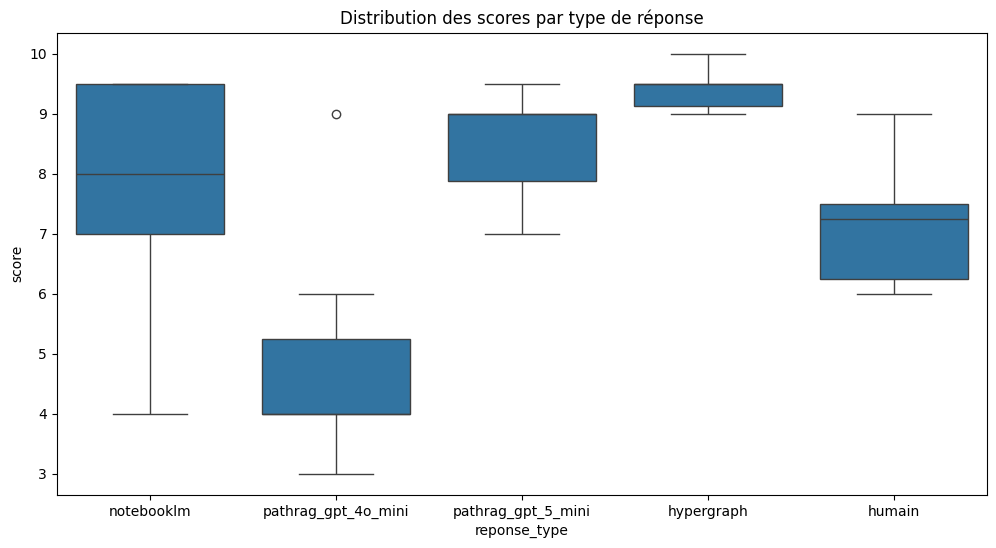

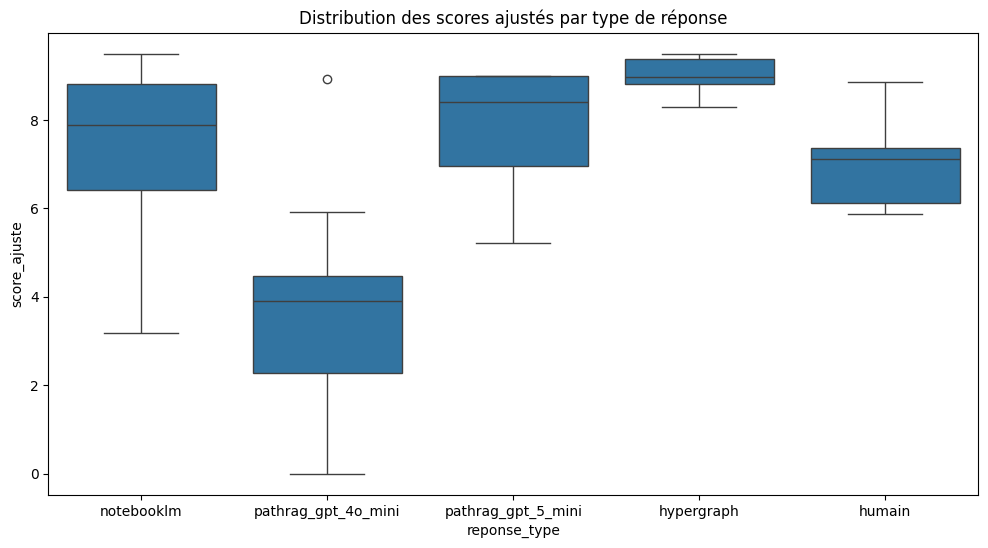

/tmp/ipykernel_335717/1961583680.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='version', y='score', hue='reponse_type', data=df, ci=None)


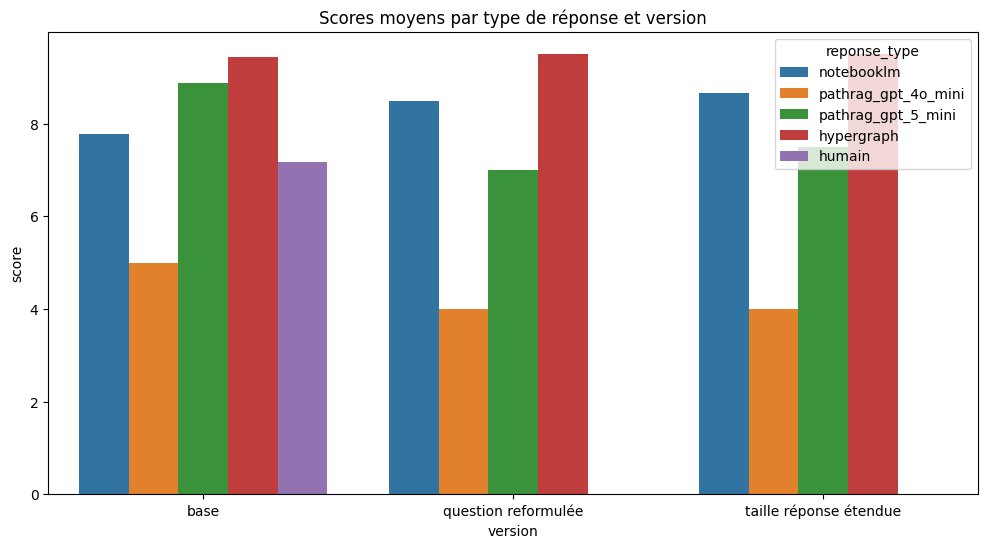

/tmp/ipykernel_335717/1961583680.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='version', y='score_ajuste', hue='reponse_type', data=df[~pd.isna(df["score_ajuste"])], ci=None)


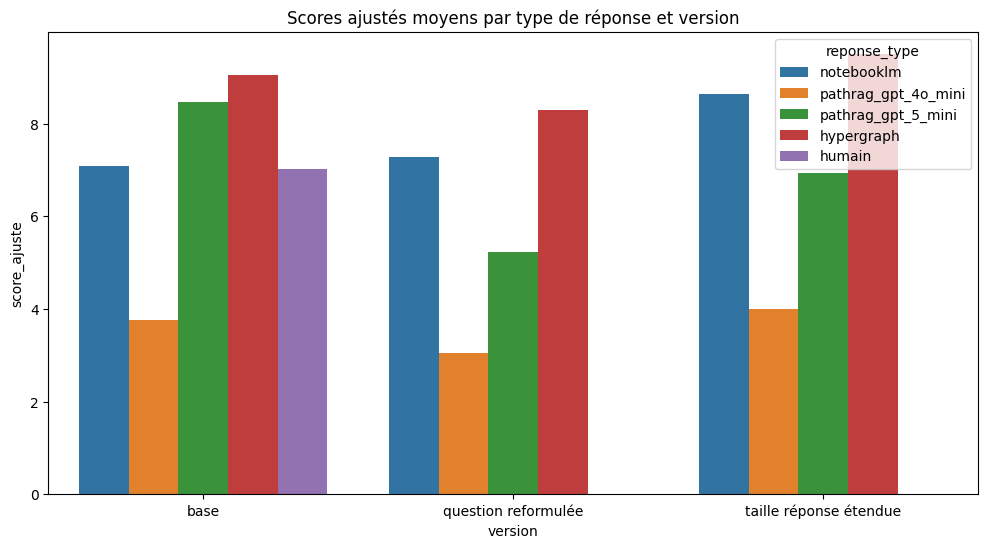

In [15]:


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Boxplot des Scores par Réponse Type et Version
# Un boxplot peut montrer la distribution des scores pour chaque combinaison de "reponse_type" et "version".

df = df_evaluations_pivoted.copy()

plt.figure(figsize=(12, 6))
sns.boxplot(x='reponse_type', y='score', data=df)
plt.title('Distribution des scores par type de réponse')
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='reponse_type', y='score_ajuste', data=df[~pd.isna(df["score_ajuste"])])
plt.title('Distribution des scores ajustés par type de réponse')
plt.show()


# 2. Graphique en Barres des Scores Moyens par Réponse Type et Version
# Un graphique en barres peut montrer les scores moyens pour chaque combinaison de "reponse_type" et "version".
plt.figure(figsize=(12, 6))
sns.barplot(x='version', y='score', hue='reponse_type', data=df, ci=None)
plt.title('Scores moyens par type de réponse et version')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='version', y='score_ajuste', hue='reponse_type', data=df[~pd.isna(df["score_ajuste"])], ci=None)
plt.title('Scores ajustés moyens par type de réponse et version')
plt.show()


In [ ]:
# Scores bruts les plus élevés par question et version
best_scores = df.loc[df.groupby(['id_question', 'version'])['score'].idxmax()]
print("MEILLEURS SCORES BRUTS par question et version:")
best_scores[['id_question', 'version', 'reponse_type', 'score']]

MEILLEURS SCORES BRUTS par question et version:


id_question                 version reponse_type  score
1            26                    base      pathrag    8.5
5            27                    base      pathrag    9.0
9            27     question reformulée      pathrag    8.7
12           27  taille réponse étendue   notebooklm    8.5
16           29                    base   notebooklm    8.5
21           31                    base      pathrag    9.0
27           34                    base   hypergraph    9.0
33           35                    base      pathrag    8.5